# 3. BiViSIONTS Model

## Section 1: MAE Model with Bivariate RGB Encoding


In [197]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from visionts import VisionTS
from visionts.models_mae import MaskedAutoencoderViT
from torchvision.transforms import ToTensor
from PIL import Image
import os
from timm.models.vision_transformer import PatchEmbed, Block
from sklearn.metrics import mean_squared_error, mean_absolute_error

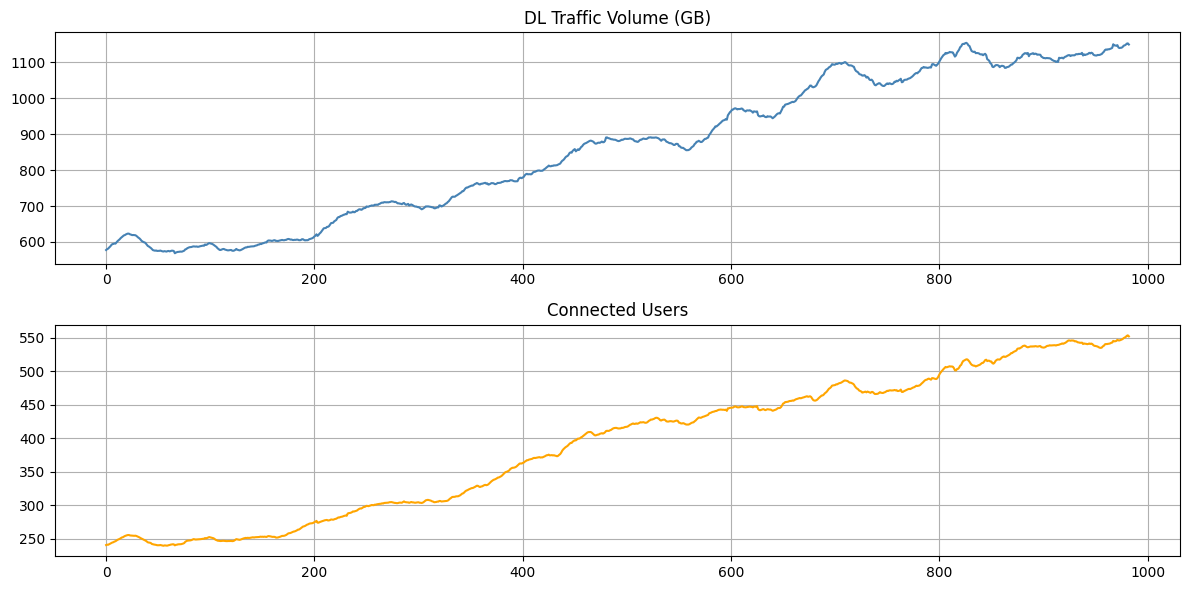

In [199]:
# STEP 0: Configurable forecast length
PRED_LEN = 100  # 👈 CHANGE THIS ONLY

# Step 2: Load from CSV - BIVARIATE DATA

df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')

CONTEXT_LEN = len(df) - PRED_LEN

# Extract both variables (bivariate)
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]
data_users = df['connected_users'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]

# Plot both variables
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(data_traffic, color='steelblue')
axs[0].set_title("DL Traffic Volume (GB)")
axs[0].grid(True)

axs[1].plot(data_users, color='orange')
axs[1].set_title("Connected Users")
axs[1].grid(True)

plt.tight_layout()
plt.show()

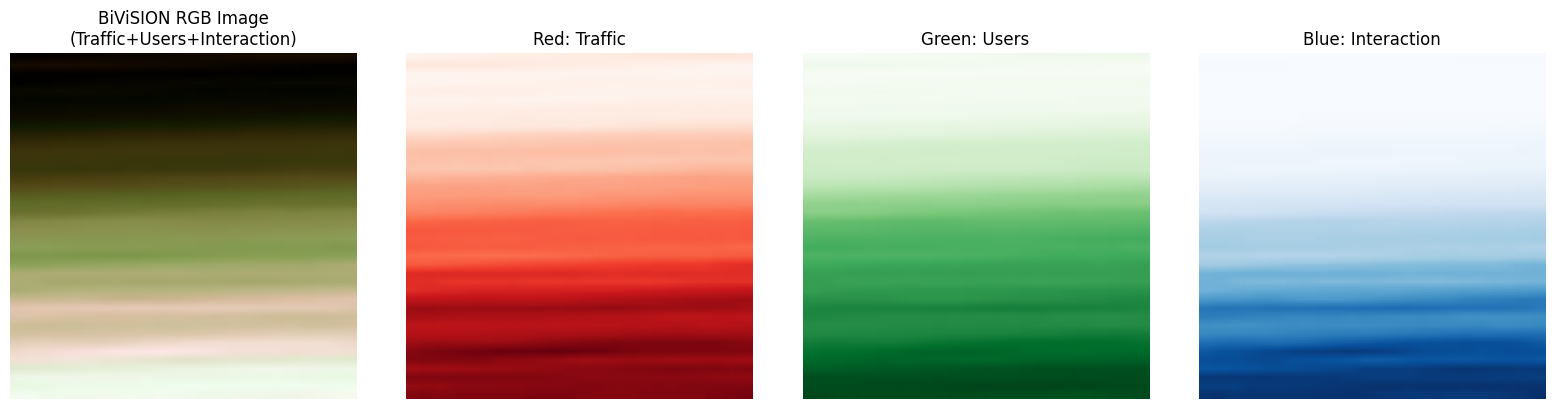

In [200]:
# Step 3: Convert BIVARIATE time series to RGB image
# Method: RGB Channel Encoding (from BiViSION Report)
def bivariate_to_rgb_image(series1, series2, context_len, pred_len, periodicity=24):
    """
    BiViSION RGB Channel Encoding Method:
    - Red Channel: Variable 1 (Traffic)
    - Green Channel: Variable 2 (Users)
    - Blue Channel: Cross-correlation or combination
    
    This preserves bivariate relationships in a single image.
    """
    total_len = context_len + pred_len
    # Truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization later
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Create blue channel as element-wise product (captures interaction)
    matrix3_norm = matrix1_norm * matrix2_norm
    
    # Convert to uint8 [0, 255]
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix3_norm * 255).astype(np.uint8)
    
    # Stack into RGB image
    height, width = r_channel.shape
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and normalization parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len
    }
    
    return img, norm_params

img, norm_params = bivariate_to_rgb_image(data_traffic, data_users, CONTEXT_LEN, PRED_LEN)

# Visualize the RGB encoding
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Full RGB
axes[0].imshow(img)
axes[0].set_title("BiViSION RGB Image\n(Traffic+Users+Interaction)")
axes[0].axis('off')

# Individual channels
img_array = np.array(img)
axes[1].imshow(img_array[:, :, 0], cmap='Reds')
axes[1].set_title("Red: Traffic")
axes[1].axis('off')

axes[2].imshow(img_array[:, :, 1], cmap='Greens')
axes[2].set_title("Green: Users")
axes[2].axis('off')

axes[3].imshow(img_array[:, :, 2], cmap='Blues')
axes[3].set_title("Blue: Interaction")
axes[3].axis('off')

plt.tight_layout()
plt.show()

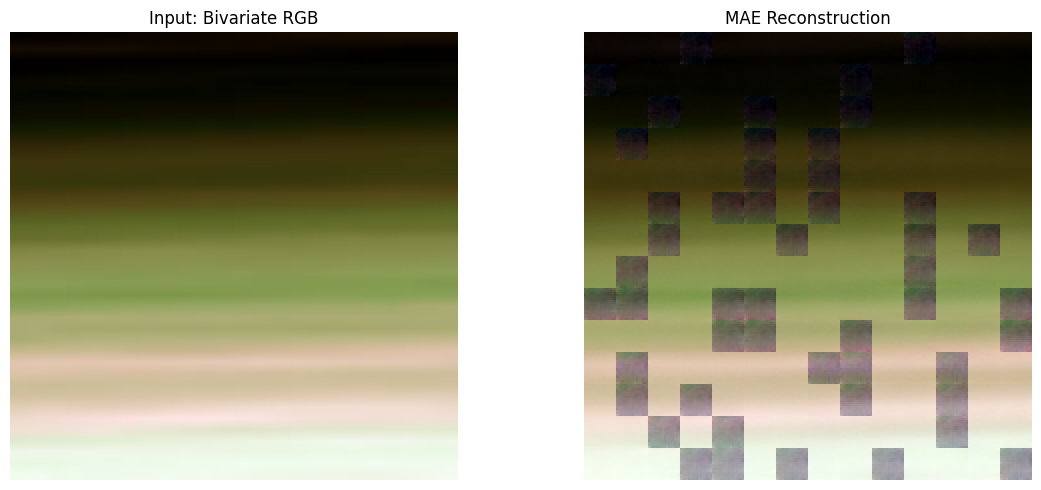

In [201]:
# Step 4: Run MAE reconstruction on BIVARIATE RGB image
model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model'], strict=False)
model.eval()

x = ToTensor()(img).unsqueeze(0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(x, mask_ratio=0.75)
    pred = model.forward_decoder(latent, ids_restore)
    output = model.unpatchify(pred).squeeze().permute(1, 2, 0).numpy()

output = np.clip(output * 255, 0, 255).astype(np.uint8)
reconstructed_img = Image.fromarray(output, mode='RGB')

# Visualize reconstruction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img)
axes[0].set_title("Input: Bivariate RGB")
axes[0].axis('off')

axes[1].imshow(reconstructed_img)
axes[1].set_title("MAE Reconstruction")
axes[1].axis('off')

plt.tight_layout()
plt.show()

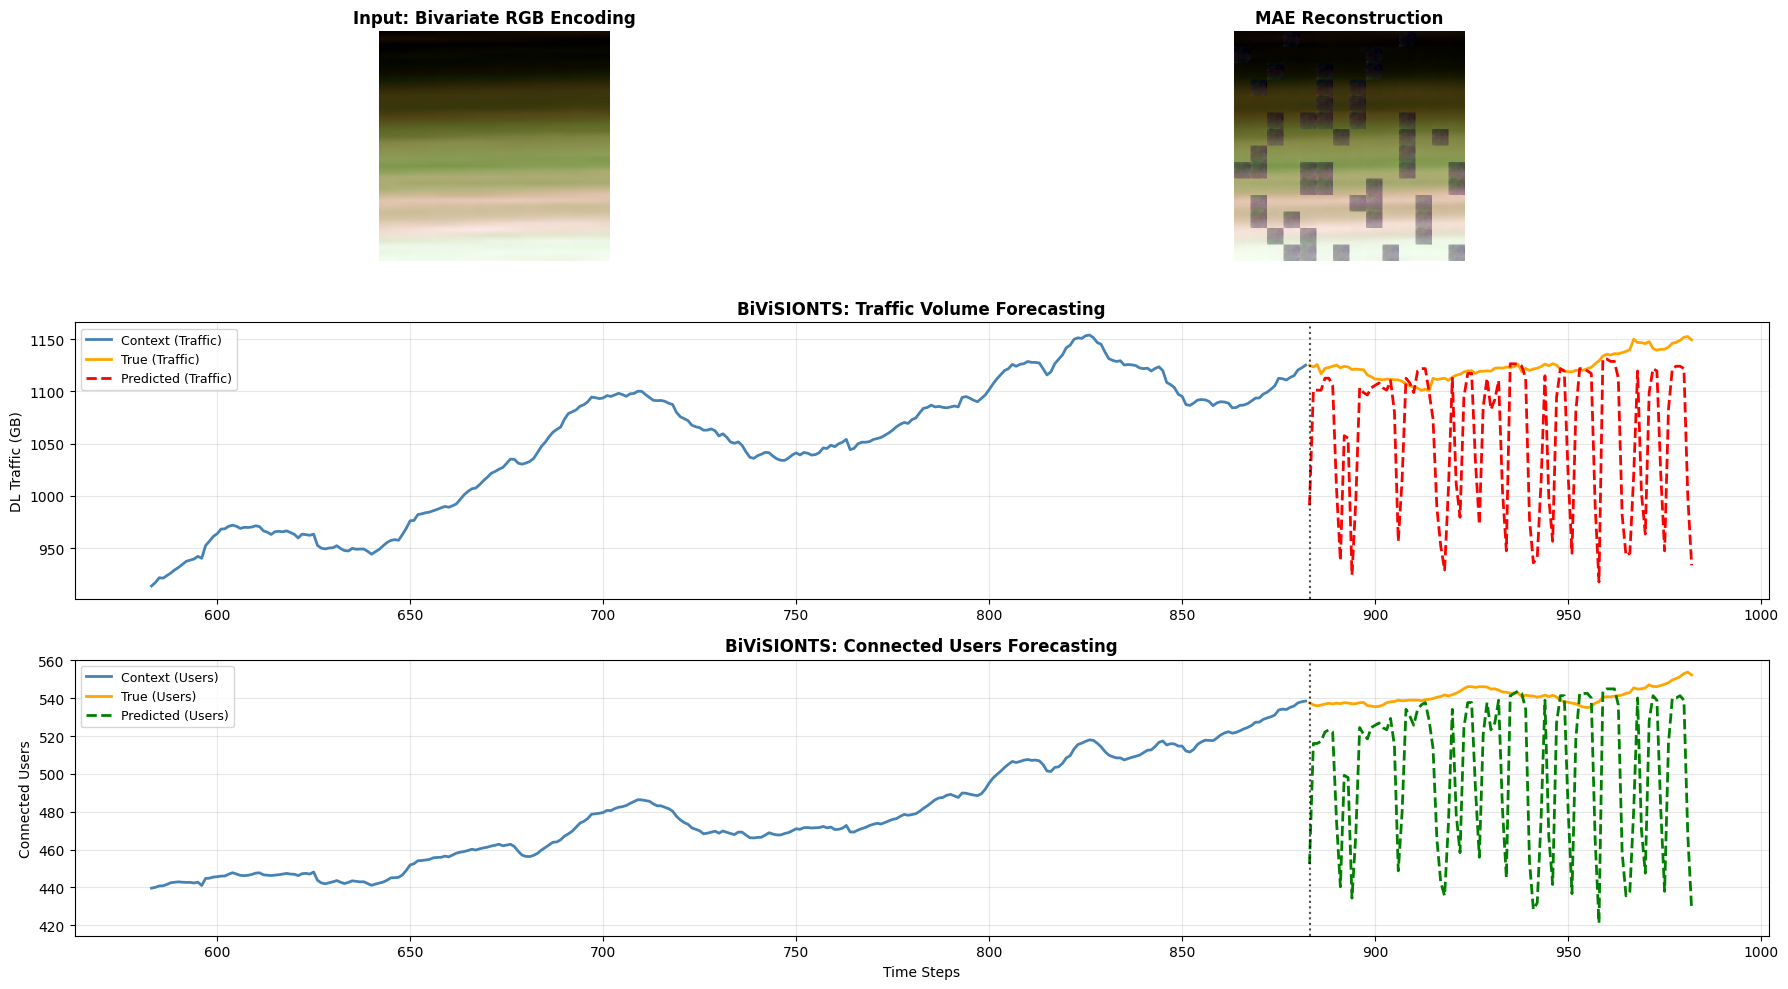

📊 BiViSIONTS Evaluation - MAE Model (RGB Channel Encoding)

🔴 DL Traffic Volume:
  MSE  = 9150.7388
  MAE  = 66.2081
  RMSE = 95.6595
  ✅ Success Rate (±10%): 69.00%

🟢 Connected Users:
  MSE  = 2989.1375
  MAE  = 38.9750
  RMSE = 54.6730
  ✅ Success Rate (±10%): 64.00%


In [202]:
PLOT_CONTEXT_LEN = 300  # 👈 Only change this to zoom in or out

# Step 5: Decode BIVARIATE forecasts from reconstructed RGB image
def rgb_image_to_bivariate(img, norm_params, periodicity=24):
    """
    Decode RGB image back to two time series
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Extract channels
    r_channel = img_array[:, :, 0]  # Traffic
    g_channel = img_array[:, :, 1]  # Users
    
    # Flatten
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

# Decode reconstructed image
recon_traffic, recon_users = rgb_image_to_bivariate(reconstructed_img, norm_params)

# Extract forecast portions
forecast_traffic = recon_traffic[-PRED_LEN:]
forecast_users = recon_users[-PRED_LEN:]

# Ground truth
true_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
true_users = data_users[:CONTEXT_LEN + PRED_LEN]

# --- Visualization ---
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1.2, 1.2])

# Row 1: Images
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img)
ax1.set_title("Input: Bivariate RGB Encoding", fontsize=12, fontweight='bold')
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(reconstructed_img)
ax2.set_title("MAE Reconstruction", fontsize=12, fontweight='bold')
ax2.axis("off")

# Row 2: Traffic forecasting
ax3 = fig.add_subplot(gs[1, :])
plot_start = max(0, CONTEXT_LEN - PLOT_CONTEXT_LEN)
ax3.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_traffic[plot_start:CONTEXT_LEN],
    label="Context (Traffic)", color="steelblue", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Traffic)", color="orange", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_traffic, label="Predicted (Traffic)", color="red", linewidth=2, linestyle='--'
)
ax3.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.set_title("BiViSIONTS: Traffic Volume Forecasting", fontsize=12, fontweight='bold')
ax3.set_ylabel("DL Traffic (GB)", fontsize=10)
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# Row 3: Users forecasting
ax4 = fig.add_subplot(gs[2, :])
ax4.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_users[plot_start:CONTEXT_LEN],
    label="Context (Users)", color="steelblue", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Users)", color="orange", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_users, label="Predicted (Users)", color="green", linewidth=2, linestyle='--'
)
ax4.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax4.set_title("BiViSIONTS: Connected Users Forecasting", fontsize=12, fontweight='bold')
ax4.set_xlabel("Time Steps", fontsize=10)
ax4.set_ylabel("Connected Users", fontsize=10)
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Evaluation Metrics ---
true_traffic_forecast = true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
true_users_forecast = true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Traffic metrics
mse_traffic = mean_squared_error(true_traffic_forecast, forecast_traffic)
mae_traffic = mean_absolute_error(true_traffic_forecast, forecast_traffic)
rmse_traffic = np.sqrt(mse_traffic)

# Users metrics
mse_users = mean_squared_error(true_users_forecast, forecast_users)
mae_users = mean_absolute_error(true_users_forecast, forecast_users)
rmse_users = np.sqrt(mse_users)

# Success rates (±10% tolerance)
tolerance = 0.10
success_traffic = (np.abs(forecast_traffic - true_traffic_forecast) <= tolerance * np.abs(true_traffic_forecast)).sum() / len(true_traffic_forecast)
success_users = (np.abs(forecast_users - true_users_forecast) <= tolerance * np.abs(true_users_forecast)).sum() / len(true_users_forecast)

# Print results
print("=" * 70)
print("📊 BiViSIONTS Evaluation - MAE Model (RGB Channel Encoding)")
print("=" * 70)
print(f"\n🔴 DL Traffic Volume:")
print(f"  MSE  = {mse_traffic:.4f}")
print(f"  MAE  = {mae_traffic:.4f}")
print(f"  RMSE = {rmse_traffic:.4f}")
print(f"  ✅ Success Rate (±10%): {success_traffic * 100:.2f}%")

print(f"\n🟢 Connected Users:")
print(f"  MSE  = {mse_users:.4f}")
print(f"  MAE  = {mae_users:.4f}")
print(f"  RMSE = {rmse_users:.4f}")
print(f"  ✅ Success Rate (±10%): {success_users * 100:.2f}%")
print("=" * 70)

## Section 2: VisionTS Model with Bivariate RGB Encoding


In [203]:
# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [205]:
# CONFIG
PRED_LEN = 100
CONTEXT_LEN = len(df) - PRED_LEN
PLOT_CONTEXT_LEN = 300

DEVICE = 'cpu'  # or 'cuda:0'

# Load BIVARIATE data
df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()
data_users = df['connected_users'].values.squeeze()

# Split into context and forecast
x_traffic = data_traffic[:CONTEXT_LEN]
y_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

x_users = data_users[:CONTEXT_LEN]
y_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

print(f"Context length: {CONTEXT_LEN}")
print(f"Prediction length: {PRED_LEN}")
print(f"Traffic range: [{x_traffic.min():.2f}, {x_traffic.max():.2f}]")
print(f"Users range: [{x_users.min():.2f}, {x_users.max():.2f}]")

Context length: 883
Prediction length: 100
Traffic range: [568.59, 1153.98]
Users range: [239.62, 538.46]


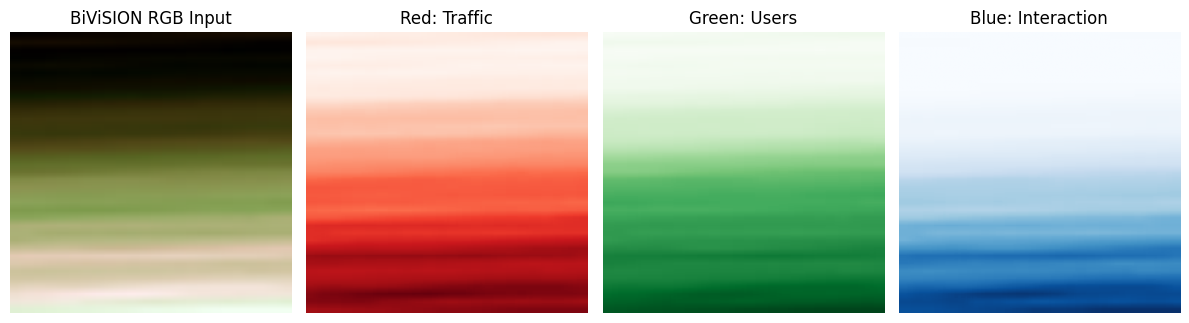

In [206]:
# Create BIVARIATE RGB image for VisionTS
def create_bivariate_visionts_input(traffic, users, periodicity=24):
    """
    Create bivariate RGB image preserving relationships
    """
    # Pad to make divisible by periodicity
    pad_len = (periodicity - len(traffic) % periodicity) % periodicity
    if pad_len > 0:
        traffic = np.pad(traffic, (0, pad_len), mode='edge')
        users = np.pad(users, (0, pad_len), mode='edge')
    
    # Reshape into matrices
    matrix_traffic = traffic.reshape(-1, periodicity)
    matrix_users = users.reshape(-1, periodicity)
    
    # Store normalization params
    min_t, max_t = matrix_traffic.min(), matrix_traffic.max()
    min_u, max_u = matrix_users.min(), matrix_users.max()
    
    # Normalize
    matrix_traffic_norm = (matrix_traffic - min_t) / (max_t - min_t)
    matrix_users_norm = (matrix_users - min_u) / (max_u - min_u)
    matrix_interaction = matrix_traffic_norm * matrix_users_norm
    
    # Create RGB
    r = (matrix_traffic_norm * 255).astype(np.uint8)
    g = (matrix_users_norm * 255).astype(np.uint8)
    b = (matrix_interaction * 255).astype(np.uint8)
    
    rgb = np.stack([r, g, b], axis=-1)
    img = Image.fromarray(rgb, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    return img, {'min_t': min_t, 'max_t': max_t, 'min_u': min_u, 'max_u': max_u, 'pad_len': pad_len}

# Create input image
input_img, norm_params = create_bivariate_visionts_input(x_traffic, x_users)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(input_img)
plt.title("BiViSION RGB Input")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(np.array(input_img)[:, :, 0], cmap='Reds')
plt.title("Red: Traffic")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(np.array(input_img)[:, :, 1], cmap='Greens')
plt.title("Green: Users")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(np.array(input_img)[:, :, 2], cmap='Blues')
plt.title("Blue: Interaction")
plt.axis('off')

plt.tight_layout()
plt.show()

C:\Users\sashika_07842\AppData\Local\Temp\1\ipykernel_23088\4204397649.py:69: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
C:\Users\sashika_07842\AppData\Local\Temp\1\ipykernel_23088\4204397649.py:96: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  recon_img = Image.fromarray(recon_rgb, mode='RGB')


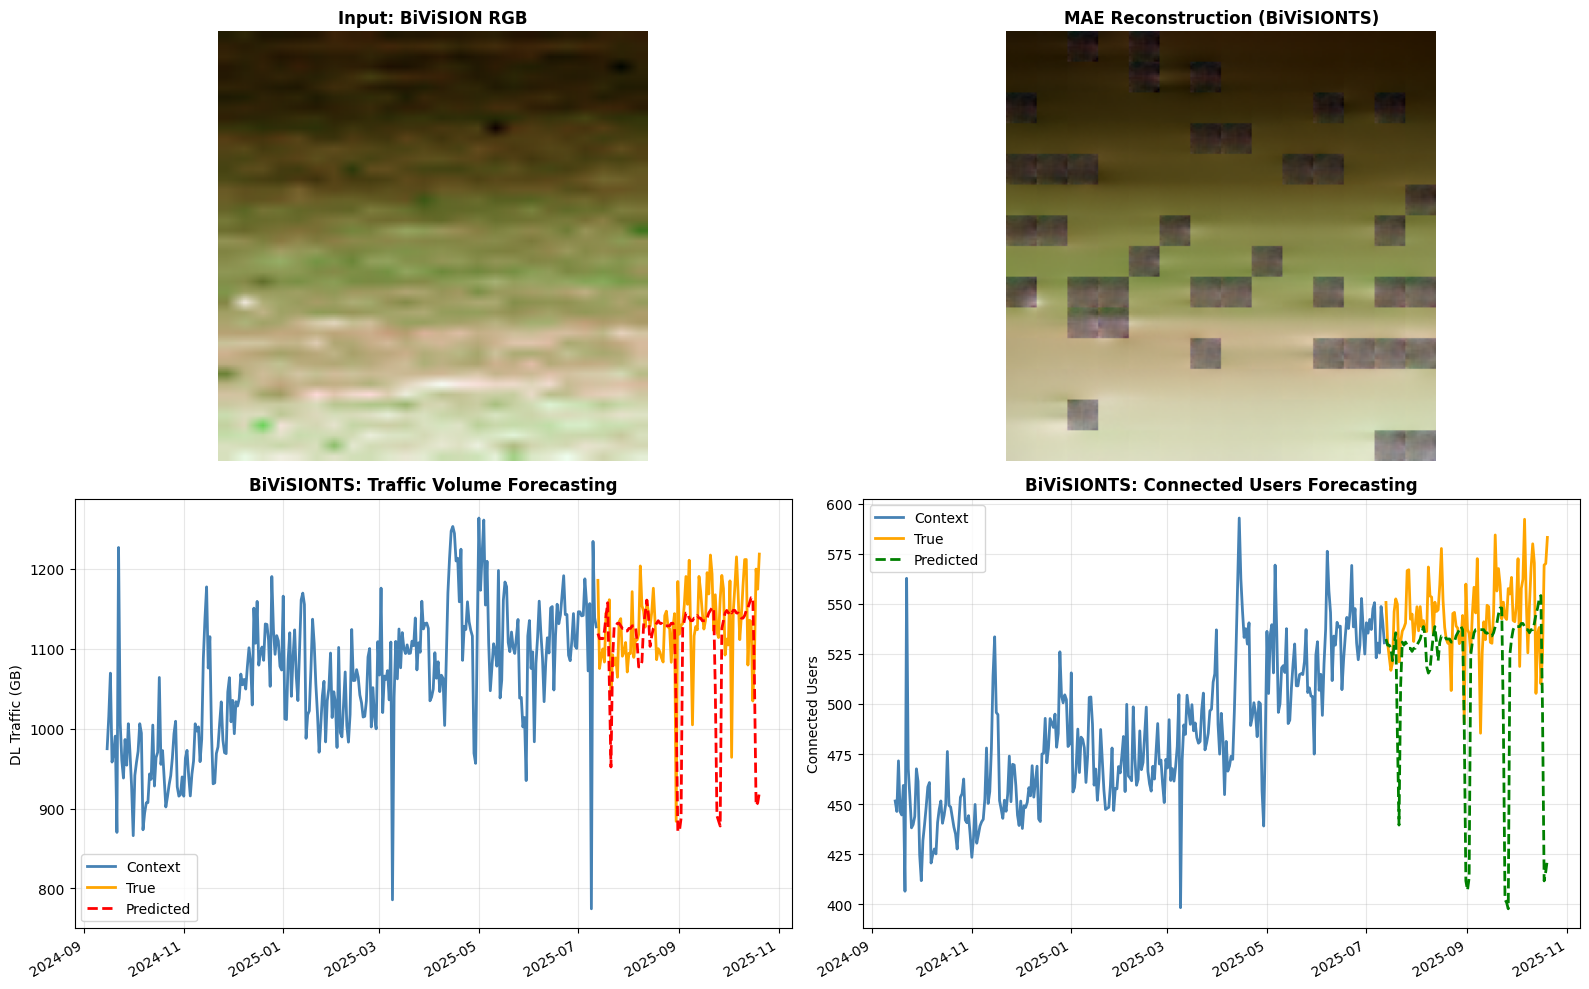

📊 BiViSIONTS Evaluation - Section 2 (RGB Channel Encoding)

🔴 DL Traffic Volume:
  MSE  = 8995.6080
  MAE  = 59.8932
  RMSE = 94.8452
  ✅ Success Rate (±10%): 85.00%

🟢 Connected Users:
  MSE  = 2490.2161
  MAE  = 29.9698
  RMSE = 49.9021
  ✅ Success Rate (±10%): 87.00%


In [ ]:
# Load VisionTS model
from visionts import VisionTS
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


model = VisionTS('mae_base', './ckpt/').to(DEVICE)
model.update_config(
    context_len=CONTEXT_LEN,
    pred_len=PRED_LEN,
    align_const=1,
    norm_const=1,
    periodicity=24
)
model.eval()

# Since VisionTS processes single-channel input, we need to handle RGB differently
# Let's use the MAE model directly for RGB processing
from visionts.models_mae import MaskedAutoencoderViT

mae_model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
mae_model.load_state_dict(ckpt['model'], strict=False)
mae_model.eval()
mae_model.to(DEVICE)

# Create bivariate RGB image from FULL series (context + forecast)
# This matches the approach used in Section 1
full_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
full_users = data_users[:CONTEXT_LEN + PRED_LEN]

# Use the same encoding function from Section 1
def bivariate_to_rgb_image_v2(series1, series2, periodicity=24):
    """
    BiViSION RGB Channel Encoding - matches Section 1
    """
    total_len = len(series1)
    # Truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization later
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Create blue channel as element-wise product (captures interaction)
    matrix3_norm = matrix1_norm * matrix2_norm
    
    # Convert to uint8 [0, 255]
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix3_norm * 255).astype(np.uint8)
    
    # Stack into RGB image
    height, width = r_channel.shape
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and normalization parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len
    }
    
    return img, norm_params

# Create input image from full series
input_img_full, norm_params_full = bivariate_to_rgb_image_v2(full_traffic, full_users)

# Convert RGB image to tensor
x_tensor = ToTensor()(input_img_full).unsqueeze(0).to(DEVICE)

# Run forward pass through MAE
with torch.no_grad():
    # latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=0.75)
    latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=0.80)
    pred = mae_model.forward_decoder(latent, ids_restore)
    recon_tensor = mae_model.unpatchify(pred)

# Convert reconstruction back to image
recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
recon_img = Image.fromarray(recon_rgb, mode='RGB')

# Decode both variables from reconstruction using Section 1's function
def rgb_image_to_bivariate_v2(img, norm_params, periodicity=24):
    """
    Decode RGB image back to two time series - matches Section 1
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Extract channels
    r_channel = img_array[:, :, 0]  # Traffic
    g_channel = img_array[:, :, 1]  # Users
    
    # Flatten
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

# Decode reconstructed image
recon_traffic_full, recon_users_full = rgb_image_to_bivariate_v2(recon_img, norm_params_full)

# Extract forecast portions (last PRED_LEN points)
forecast_traffic = recon_traffic_full[-PRED_LEN:]
forecast_users = recon_users_full[-PRED_LEN:]

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Images
axes[0, 0].imshow(input_img_full)
axes[0, 0].set_title("Input: BiViSION RGB", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(recon_img)
axes[0, 1].set_title("MAE Reconstruction (BiViSIONTS)", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Traffic forecast
timestamps = pd.to_datetime(df['date'])
time_x = timestamps[:CONTEXT_LEN]
time_y = timestamps[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

axes[1, 0].plot(time_x[-PLOT_CONTEXT_LEN:], x_traffic[-PLOT_CONTEXT_LEN:], 
                label="Context", color='steelblue', linewidth=2)
axes[1, 0].plot(time_y, y_traffic, label="True", color='orange', linewidth=2)
axes[1, 0].plot(time_y, forecast_traffic, label="Predicted", 
                color='red', linewidth=2, linestyle='--')
axes[1, 0].set_title("BiViSIONTS: Traffic Volume Forecasting", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("DL Traffic (GB)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Users forecast
axes[1, 1].plot(time_x[-PLOT_CONTEXT_LEN:], x_users[-PLOT_CONTEXT_LEN:], 
                label="Context", color='steelblue', linewidth=2)
axes[1, 1].plot(time_y, y_users, label="True", color='orange', linewidth=2)
axes[1, 1].plot(time_y, forecast_users, label="Predicted", 
                color='green', linewidth=2, linestyle='--')
axes[1, 1].set_title("BiViSIONTS: Connected Users Forecasting", fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel("Connected Users")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Traffic metrics
mse_traffic = mean_squared_error(y_traffic, forecast_traffic)
mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
rmse_traffic = np.sqrt(mse_traffic)
success_traffic = (np.abs(forecast_traffic - y_traffic) <= 0.10 * np.abs(y_traffic)).sum() / len(y_traffic)

# Users metrics
mse_users = mean_squared_error(y_users, forecast_users)
mae_users = mean_absolute_error(y_users, forecast_users)
rmse_users = np.sqrt(mse_users)
success_users = (np.abs(forecast_users - y_users) <= 0.10 * np.abs(y_users)).sum() / len(y_users)

# Print results
print("=" * 70)
print("📊 BiViSIONTS Evaluation - Section 2 (RGB Channel Encoding)")
print("=" * 70)
print(f"\n🔴 DL Traffic Volume:")
print(f"  MSE  = {mse_traffic:.4f}")
print(f"  MAE  = {mae_traffic:.4f}")
print(f"  RMSE = {rmse_traffic:.4f}")
print(f"  ✅ Success Rate (±10%): {success_traffic * 100:.2f}%")

print(f"\n🟢 Connected Users:")
print(f"  MSE  = {mse_users:.4f}")
print(f"  MAE  = {mae_users:.4f}")
print(f"  RMSE = {rmse_users:.4f}")
print(f"  ✅ Success Rate (±10%): {success_users * 100:.2f}%")
print("=" * 70)

🔄 Running BiViSIONTS (RGB Channel Encoding) 1000 iterations for convergence analysis...
✓ Completed 10/1000 iterations
✓ Completed 20/1000 iterations
✓ Completed 30/1000 iterations
✓ Completed 40/1000 iterations
✓ Completed 50/1000 iterations
✓ Completed 60/1000 iterations
✓ Completed 70/1000 iterations
✓ Completed 80/1000 iterations
✓ Completed 90/1000 iterations
✓ Completed 100/1000 iterations
✓ Completed 110/1000 iterations
✓ Completed 120/1000 iterations
✓ Completed 130/1000 iterations
✓ Completed 140/1000 iterations
✓ Completed 150/1000 iterations
✓ Completed 160/1000 iterations
✓ Completed 170/1000 iterations
✓ Completed 180/1000 iterations
✓ Completed 190/1000 iterations
✓ Completed 200/1000 iterations
✓ Completed 210/1000 iterations
✓ Completed 220/1000 iterations
✓ Completed 230/1000 iterations
✓ Completed 240/1000 iterations
✓ Completed 250/1000 iterations
✓ Completed 260/1000 iterations
✓ Completed 270/1000 iterations
✓ Completed 280/1000 iterations
✓ Completed 290/1000 iter

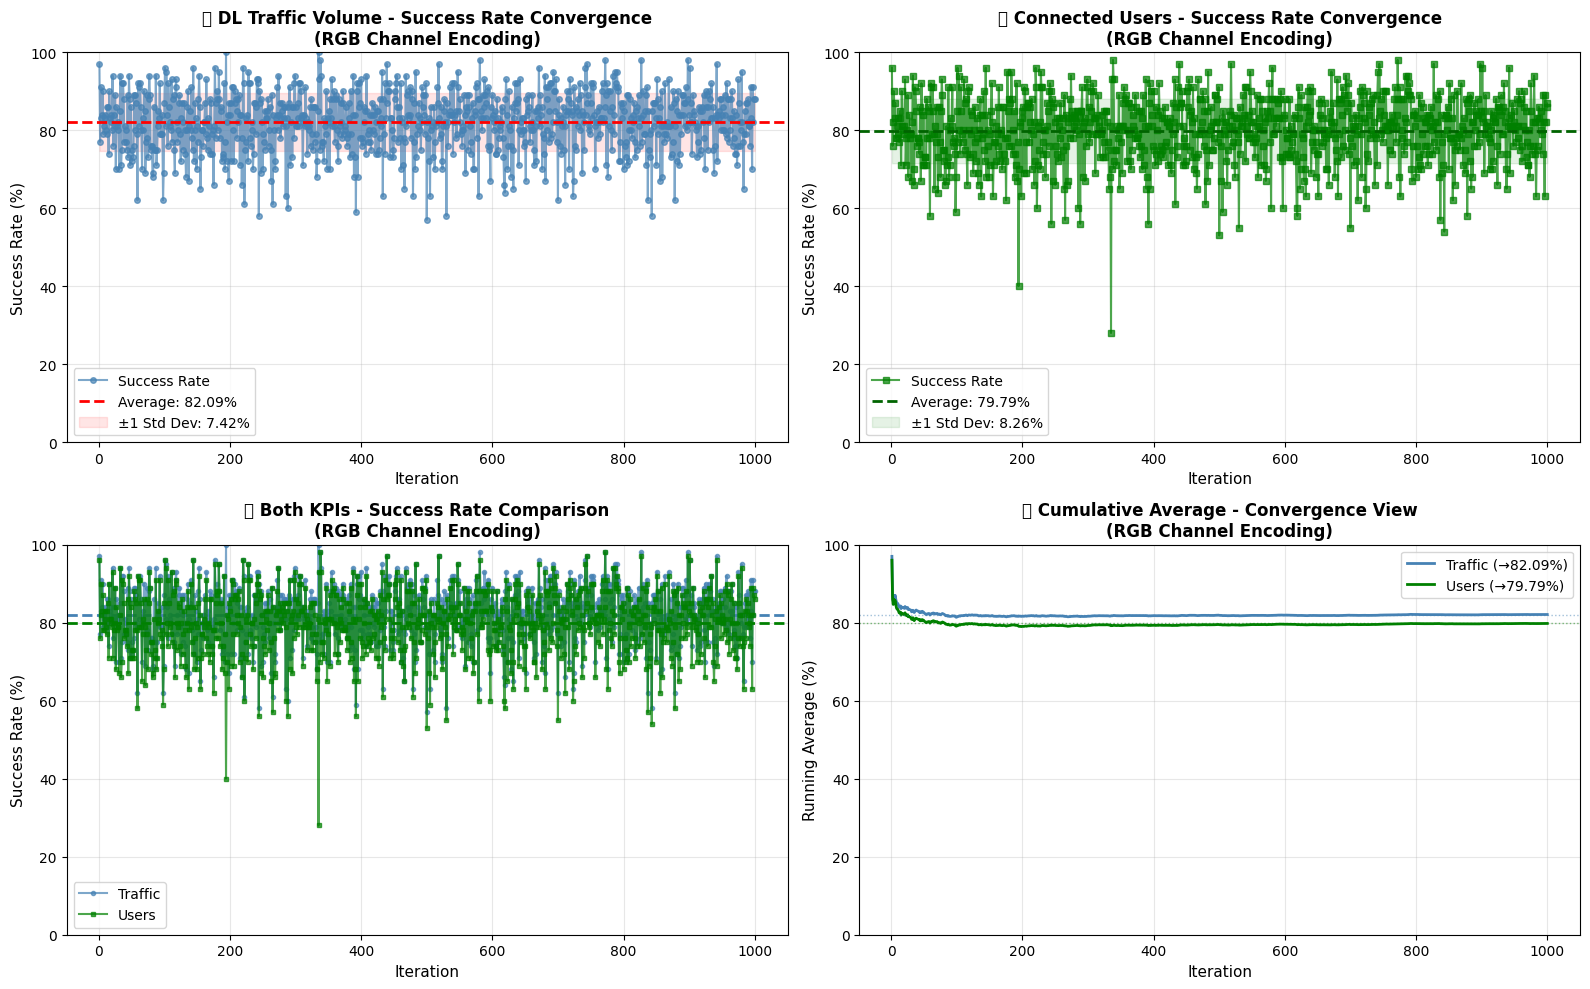

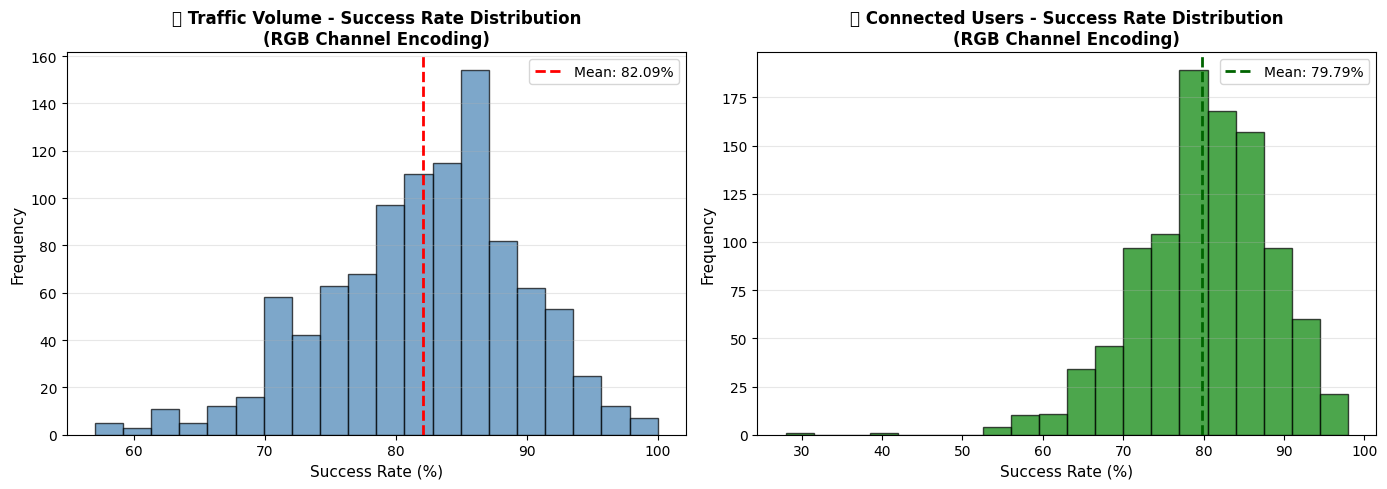


📋 Results DataFrame (First 10 rows):
   Iteration  Traffic_Success_Rate_%  Users_Success_Rate_%  Traffic_MSE  \
0          1                    97.0                  96.0  1610.781899   
1          2                    77.0                  76.0  7709.161330   
2          3                    83.0                  82.0  5822.606814   
3          4                    91.0                  90.0  3703.164284   
4          5                    84.0                  83.0  5640.415239   
5          6                    90.0                  87.0  3913.017590   
6          7                    79.0                  78.0  6945.331437   
7          8                    81.0                  78.0  6284.653180   
8          9                    83.0                  81.0  5719.634106   
9         10                    84.0                  83.0  5640.486733   

   Traffic_MAE    Users_MSE  Users_MAE  
0    28.373592   523.724199  17.442621  
1    53.555017  2517.711786  32.080257  
2    43.49528

In [209]:
# Multi-iteration Convergence Analysis for BiViSIONTS (RGB Channel Encoding)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Configuration
NUM_ITERATIONS = 1000  # Number of times to run the test
MASK_RATIO = 0.80   # Mask ratio used in MAE

print(f"🔄 Running BiViSIONTS (RGB Channel Encoding) {NUM_ITERATIONS} iterations for convergence analysis...")
print("=" * 80)

# Storage for results
traffic_success_rates = []
users_success_rates = []
traffic_mse_list = []
traffic_mae_list = []
users_mse_list = []
users_mae_list = []

# Run multiple iterations
for iteration in range(NUM_ITERATIONS):
    # Set different random seed for each iteration to get different mask patterns
    seed = 42 + iteration
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Create input image (same data, different reconstruction due to random masking)
    input_img_full, norm_params_full = bivariate_to_rgb_image_v2(full_traffic, full_users)
    
    # Convert to tensor
    x_tensor = ToTensor()(input_img_full).unsqueeze(0).to(DEVICE)
    
    # Run forward pass through MAE with random masking
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=MASK_RATIO)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    # Convert reconstruction back to image
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode both variables
    recon_traffic_full, recon_users_full = rgb_image_to_bivariate_v2(recon_img, norm_params_full)
    
    # Extract forecast portions
    forecast_traffic = recon_traffic_full[-PRED_LEN:]
    forecast_users = recon_users_full[-PRED_LEN:]
    
    # Calculate metrics for Traffic
    mse_traffic = mean_squared_error(y_traffic, forecast_traffic)
    mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
    success_traffic = (np.abs(forecast_traffic - y_traffic) <= 0.10 * np.abs(y_traffic)).sum() / len(y_traffic)
    
    # Calculate metrics for Users
    mse_users = mean_squared_error(y_users, forecast_users)
    mae_users = mean_absolute_error(y_users, forecast_users)
    success_users = (np.abs(forecast_users - y_users) <= 0.10 * np.abs(y_users)).sum() / len(y_users)
    
    # Store results
    traffic_success_rates.append(success_traffic * 100)
    users_success_rates.append(success_users * 100)
    traffic_mse_list.append(mse_traffic)
    traffic_mae_list.append(mae_traffic)
    users_mse_list.append(mse_users)
    users_mae_list.append(mae_users)
    
    # Print progress every 10 iterations
    if (iteration + 1) % 10 == 0:
        print(f"✓ Completed {iteration + 1}/{NUM_ITERATIONS} iterations")

print("=" * 80)
print("✅ All iterations completed!")
print()

# Calculate statistics
traffic_avg = np.mean(traffic_success_rates)
traffic_std = np.std(traffic_success_rates)
users_avg = np.mean(users_success_rates)
users_std = np.std(users_success_rates)

print("📊 CONVERGENCE STATISTICS (RGB Channel Encoding)")
print("=" * 80)
print(f"\n🎨 Encoding Method: RGB Channel Encoding")
print(f"  R: Traffic, G: Users, B: Interaction (R × G)")

print(f"\n🔴 DL Traffic Volume:")
print(f"  Average Success Rate: {traffic_avg:.2f}%")
print(f"  Std Deviation: {traffic_std:.2f}%")
print(f"  Min: {min(traffic_success_rates):.2f}%")
print(f"  Max: {max(traffic_success_rates):.2f}%")
print(f"  Average MSE: {np.mean(traffic_mse_list):.4f}")
print(f"  Average MAE: {np.mean(traffic_mae_list):.4f}")

print(f"\n🟢 Connected Users:")
print(f"  Average Success Rate: {users_avg:.2f}%")
print(f"  Std Deviation: {users_std:.2f}%")
print(f"  Min: {min(users_success_rates):.2f}%")
print(f"  Max: {max(users_success_rates):.2f}%")
print(f"  Average MSE: {np.mean(users_mse_list):.4f}")
print(f"  Average MAE: {np.mean(users_mae_list):.4f}")
print("=" * 80)

# Visualization: Success Rate Convergence
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

iterations = list(range(1, NUM_ITERATIONS + 1))

# Plot 1: Traffic Success Rate with Average Line
axes[0, 0].plot(iterations, traffic_success_rates, marker='o', markersize=4, 
                linewidth=1.5, color='steelblue', alpha=0.7, label='Success Rate')
axes[0, 0].axhline(y=traffic_avg, color='red', linestyle='--', linewidth=2, 
                   label=f'Average: {traffic_avg:.2f}%')
axes[0, 0].fill_between(iterations, traffic_avg - traffic_std, traffic_avg + traffic_std, 
                        color='red', alpha=0.1, label=f'±1 Std Dev: {traffic_std:.2f}%')
axes[0, 0].set_xlabel('Iteration', fontsize=11)
axes[0, 0].set_ylabel('Success Rate (%)', fontsize=11)
axes[0, 0].set_title('🔴 DL Traffic Volume - Success Rate Convergence\n(RGB Channel Encoding)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 100])

# Plot 2: Users Success Rate with Average Line
axes[0, 1].plot(iterations, users_success_rates, marker='s', markersize=4, 
                linewidth=1.5, color='green', alpha=0.7, label='Success Rate')
axes[0, 1].axhline(y=users_avg, color='darkgreen', linestyle='--', linewidth=2, 
                   label=f'Average: {users_avg:.2f}%')
axes[0, 1].fill_between(iterations, users_avg - users_std, users_avg + users_std, 
                        color='green', alpha=0.1, label=f'±1 Std Dev: {users_std:.2f}%')
axes[0, 1].set_xlabel('Iteration', fontsize=11)
axes[0, 1].set_ylabel('Success Rate (%)', fontsize=11)
axes[0, 1].set_title('🟢 Connected Users - Success Rate Convergence\n(RGB Channel Encoding)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 100])

# Plot 3: Combined Success Rates
axes[1, 0].plot(iterations, traffic_success_rates, marker='o', markersize=3, 
                linewidth=1.5, color='steelblue', alpha=0.7, label='Traffic')
axes[1, 0].axhline(y=traffic_avg, color='steelblue', linestyle='--', linewidth=2)
axes[1, 0].plot(iterations, users_success_rates, marker='s', markersize=3, 
                linewidth=1.5, color='green', alpha=0.7, label='Users')
axes[1, 0].axhline(y=users_avg, color='green', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Iteration', fontsize=11)
axes[1, 0].set_ylabel('Success Rate (%)', fontsize=11)
axes[1, 0].set_title('📊 Both KPIs - Success Rate Comparison\n(RGB Channel Encoding)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='best')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 100])

# Plot 4: Running Average (Cumulative Mean)
traffic_running_avg = [np.mean(traffic_success_rates[:i+1]) for i in range(NUM_ITERATIONS)]
users_running_avg = [np.mean(users_success_rates[:i+1]) for i in range(NUM_ITERATIONS)]

axes[1, 1].plot(iterations, traffic_running_avg, linewidth=2, 
                color='steelblue', label=f'Traffic (→{traffic_avg:.2f}%)')
axes[1, 1].plot(iterations, users_running_avg, linewidth=2, 
                color='green', label=f'Users (→{users_avg:.2f}%)')
axes[1, 1].axhline(y=traffic_avg, color='steelblue', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 1].axhline(y=users_avg, color='green', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Iteration', fontsize=11)
axes[1, 1].set_ylabel('Running Average (%)', fontsize=11)
axes[1, 1].set_title('📈 Cumulative Average - Convergence View\n(RGB Channel Encoding)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Additional: Distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(traffic_success_rates, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=traffic_avg, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {traffic_avg:.2f}%')
axes[0].set_xlabel('Success Rate (%)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('🔴 Traffic Volume - Success Rate Distribution\n(RGB Channel Encoding)', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].hist(users_success_rates, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(x=users_avg, color='darkgreen', linestyle='--', linewidth=2, 
                label=f'Mean: {users_avg:.2f}%')
axes[1].set_xlabel('Success Rate (%)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('🟢 Connected Users - Success Rate Distribution\n(RGB Channel Encoding)', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Save results to DataFrame
results_df = pd.DataFrame({
    'Iteration': iterations,
    'Traffic_Success_Rate_%': traffic_success_rates,
    'Users_Success_Rate_%': users_success_rates,
    'Traffic_MSE': traffic_mse_list,
    'Traffic_MAE': traffic_mae_list,
    'Users_MSE': users_mse_list,
    'Users_MAE': users_mae_list
})

print("\n📋 Results DataFrame (First 10 rows):")
print(results_df.head(10))

# Summary statistics
print("\n📊 SUMMARY STATISTICS (RGB Channel Encoding)")
print("=" * 80)
print(results_df.describe())
print("=" * 80)

# Attention-Weighted

## Section 1: MAE Model with Attention-Weighted Bivariate Encoding


In [103]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from visionts import VisionTS
from visionts.models_mae import MaskedAutoencoderViT
from torchvision.transforms import ToTensor
from PIL import Image
import os
from timm.models.vision_transformer import PatchEmbed, Block
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✅ Random seed set for reproducible results")

✅ Random seed set for reproducible results


In [104]:
# STEP 0: Configurable forecast length
PRED_LEN = 100  # 👈 CHANGE THIS ONLY

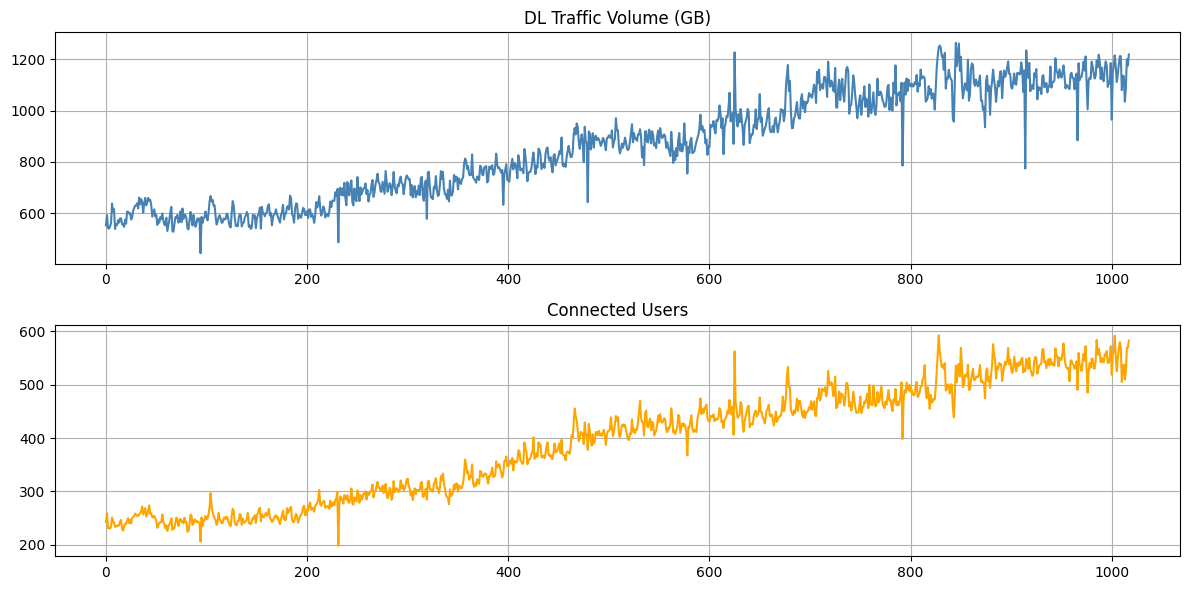

In [105]:
# Step 2: Load from CSV - BIVARIATE DATA

df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')

CONTEXT_LEN = len(df) - PRED_LEN

# Extract both variables (bivariate)
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]
data_users = df['connected_users'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]

# Plot both variables
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(data_traffic, color='steelblue')
axs[0].set_title("DL Traffic Volume (GB)")
axs[0].grid(True)

axs[1].plot(data_users, color='orange')
axs[1].set_title("Connected Users")
axs[1].grid(True)

plt.tight_layout()
plt.show()

📊 Correlation between Traffic and Users: 0.9807
🎯 Attention weight (alpha): 0.9903


C:\Users\sashika_07842\AppData\Local\Temp\1\ipykernel_23088\329672615.py:51: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)


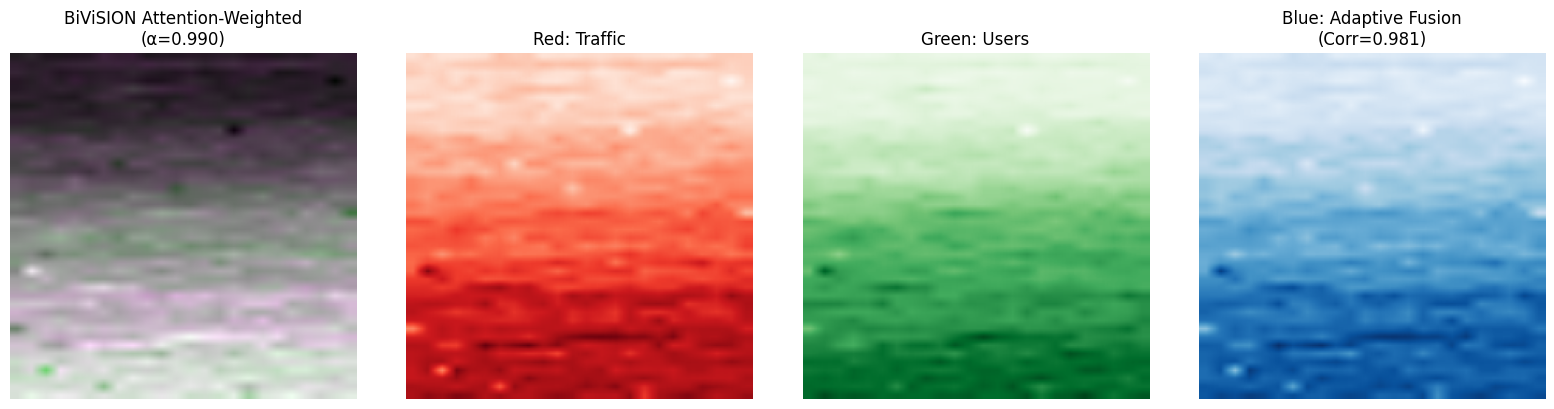

In [106]:
# Step 3: Convert BIVARIATE time series to RGB image using Attention-Weighted Fusion
def bivariate_attention_weighted_image(series1, series2, context_len, pred_len, periodicity=24):
    """
    BiViSION Attention-Weighted Fusion Method:
    - Red Channel: Variable 1 (Traffic)
    - Green Channel: Variable 2 (Users)
    - Blue Channel: Correlation-weighted adaptive fusion
    
    The attention weight is computed based on the correlation between variables.
    """
    total_len = context_len + pred_len
    # Truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization later
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Compute global correlation coefficient
    corr = np.corrcoef(series1[:usable_len], series2[:usable_len])[0, 1]
    # Normalize correlation to [0, 1] range for alpha weight
    alpha = (corr + 1) / 2  # Maps [-1, 1] to [0, 1]
    
    print(f"📊 Correlation between Traffic and Users: {corr:.4f}")
    print(f"🎯 Attention weight (alpha): {alpha:.4f}")
    
    # Create blue channel as correlation-weighted adaptive fusion
    # When correlation is high (alpha → 1), more weight on series1
    # When correlation is low (alpha → 0.5), balanced weight
    # When negative correlation (alpha → 0), more weight on series2
    matrix_fusion = alpha * matrix1_norm + (1 - alpha) * matrix2_norm
    
    # Convert to uint8 [0, 255]
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    # Stack into RGB image
    height, width = r_channel.shape
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and normalization parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len,
        'alpha': alpha,
        'correlation': corr
    }
    
    return img, norm_params

img, norm_params = bivariate_attention_weighted_image(data_traffic, data_users, CONTEXT_LEN, PRED_LEN)

# Visualize the RGB encoding
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Full RGB
axes[0].imshow(img)
axes[0].set_title(f"BiViSION Attention-Weighted\n(α={norm_params['alpha']:.3f})")
axes[0].axis('off')

# Individual channels
img_array = np.array(img)
axes[1].imshow(img_array[:, :, 0], cmap='Reds')
axes[1].set_title("Red: Traffic")
axes[1].axis('off')

axes[2].imshow(img_array[:, :, 1], cmap='Greens')
axes[2].set_title("Green: Users")
axes[2].axis('off')

axes[3].imshow(img_array[:, :, 2], cmap='Blues')
axes[3].set_title(f"Blue: Adaptive Fusion\n(Corr={norm_params['correlation']:.3f})")
axes[3].axis('off')

plt.tight_layout()
plt.show()

C:\Users\sashika_07842\AppData\Local\Temp\1\ipykernel_23088\2460002025.py:20: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  reconstructed_img = Image.fromarray(output, mode='RGB')


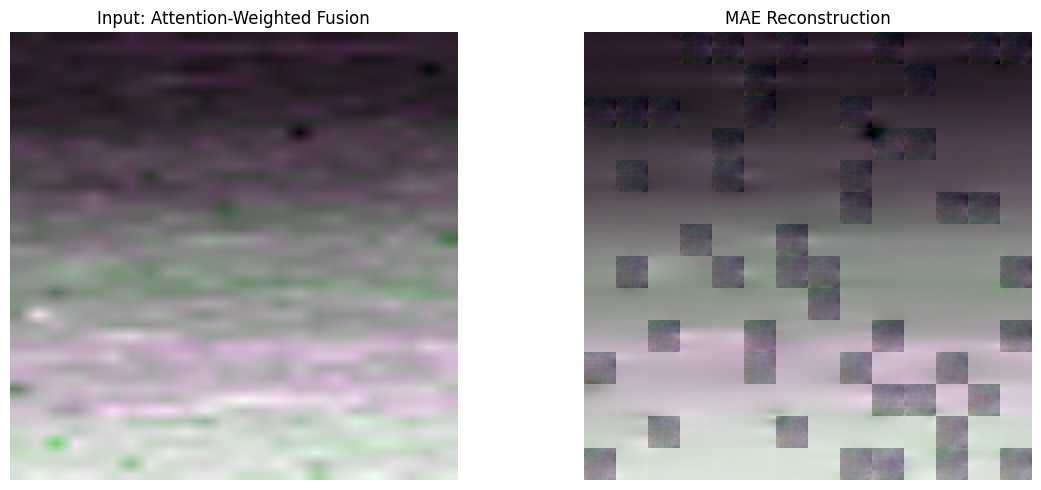

In [107]:
# Step 4: Run MAE reconstruction on BIVARIATE attention-weighted image
model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model'], strict=False)
model.eval()

x = ToTensor()(img).unsqueeze(0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(x, mask_ratio=0.75)
    pred = model.forward_decoder(latent, ids_restore)
    output = model.unpatchify(pred).squeeze().permute(1, 2, 0).numpy()

output = np.clip(output * 255, 0, 255).astype(np.uint8)
reconstructed_img = Image.fromarray(output, mode='RGB')

# Visualize reconstruction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img)
axes[0].set_title("Input: Attention-Weighted Fusion")
axes[0].axis('off')

axes[1].imshow(reconstructed_img)
axes[1].set_title("MAE Reconstruction")
axes[1].axis('off')

plt.tight_layout()
plt.show()

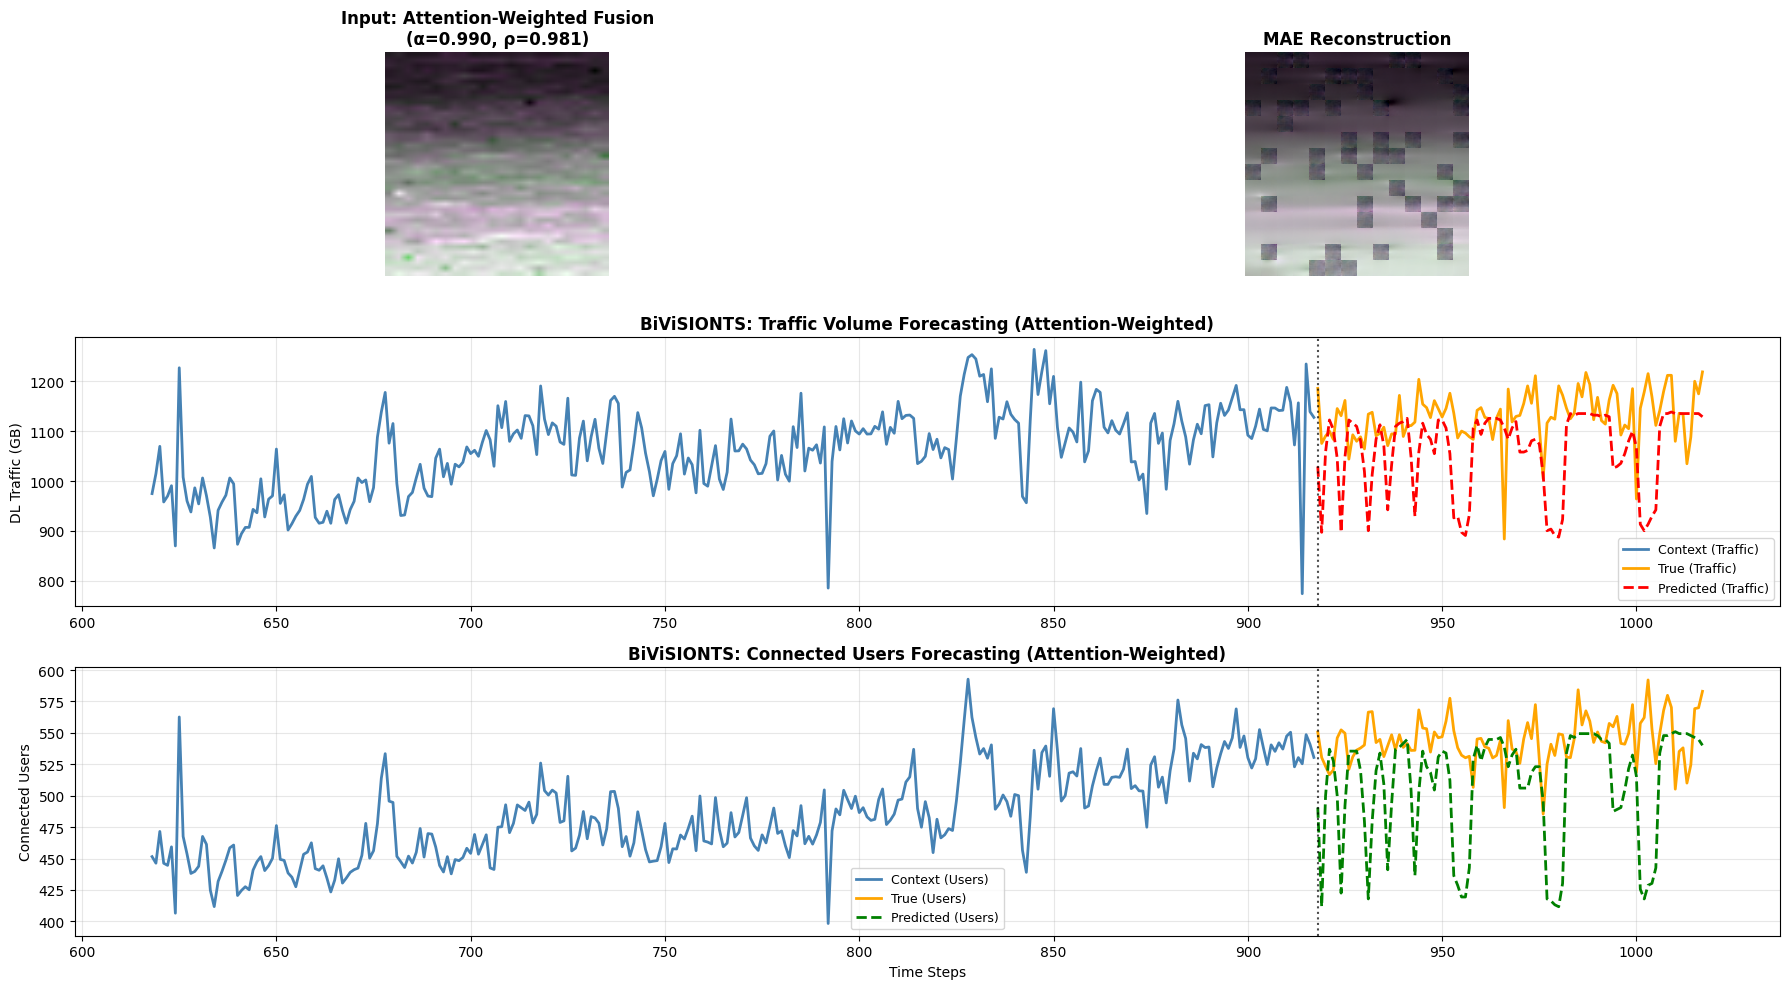

📊 BiViSIONTS Evaluation - MAE Model (Attention-Weighted Fusion)

🎯 Attention Parameters:
  Correlation (ρ) = 0.9807
  Attention weight (α) = 0.9903

🔴 DL Traffic Volume:
  MSE  = 13795.2105
  MAE  = 86.7109
  RMSE = 117.4530
  ✅ Success Rate (±10%): 70.00%

🟢 Connected Users:
  MSE  = 3734.1141
  MAE  = 43.4979
  RMSE = 61.1074
  ✅ Success Rate (±10%): 72.00%


In [109]:
PLOT_CONTEXT_LEN = 300  # 👈 Only change this to zoom in or out

# Step 5: Decode BIVARIATE forecasts from reconstructed attention-weighted image
def attention_weighted_image_to_bivariate(img, norm_params, periodicity=24):
    """
    Decode attention-weighted RGB image back to two time series
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Extract channels
    r_channel = img_array[:, :, 0]  # Traffic
    g_channel = img_array[:, :, 1]  # Users
    # Blue channel contains fusion but we only need original variables
    
    # Flatten
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

# Decode reconstructed image
recon_traffic, recon_users = attention_weighted_image_to_bivariate(reconstructed_img, norm_params)

# Extract forecast portions
forecast_traffic = recon_traffic[-PRED_LEN:]
forecast_users = recon_users[-PRED_LEN:]

# Ground truth
true_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
true_users = data_users[:CONTEXT_LEN + PRED_LEN]

# --- Visualization ---
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1.2, 1.2])

# Row 1: Images
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img)
ax1.set_title(f"Input: Attention-Weighted Fusion\n(α={norm_params['alpha']:.3f}, ρ={norm_params['correlation']:.3f})", 
              fontsize=12, fontweight='bold')
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(reconstructed_img)
ax2.set_title("MAE Reconstruction", fontsize=12, fontweight='bold')
ax2.axis("off")

# Row 2: Traffic forecasting
ax3 = fig.add_subplot(gs[1, :])
plot_start = max(0, CONTEXT_LEN - PLOT_CONTEXT_LEN)
ax3.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_traffic[plot_start:CONTEXT_LEN],
    label="Context (Traffic)", color="steelblue", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Traffic)", color="orange", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_traffic, label="Predicted (Traffic)", color="red", linewidth=2, linestyle='--'
)
ax3.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.set_title("BiViSIONTS: Traffic Volume Forecasting (Attention-Weighted)", fontsize=12, fontweight='bold')
ax3.set_ylabel("DL Traffic (GB)", fontsize=10)
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# Row 3: Users forecasting
ax4 = fig.add_subplot(gs[2, :])
ax4.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_users[plot_start:CONTEXT_LEN],
    label="Context (Users)", color="steelblue", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Users)", color="orange", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_users, label="Predicted (Users)", color="green", linewidth=2, linestyle='--'
)
ax4.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax4.set_title("BiViSIONTS: Connected Users Forecasting (Attention-Weighted)", fontsize=12, fontweight='bold')
ax4.set_xlabel("Time Steps", fontsize=10)
ax4.set_ylabel("Connected Users", fontsize=10)
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Evaluation Metrics ---
true_traffic_forecast = true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
true_users_forecast = true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Traffic metrics
mse_traffic = mean_squared_error(true_traffic_forecast, forecast_traffic)
mae_traffic = mean_absolute_error(true_traffic_forecast, forecast_traffic)
rmse_traffic = np.sqrt(mse_traffic)

# Users metrics
mse_users = mean_squared_error(true_users_forecast, forecast_users)
mae_users = mean_absolute_error(true_users_forecast, forecast_users)
rmse_users = np.sqrt(mse_users)

# Success rates (±10% tolerance)
tolerance = 0.10
success_traffic = (np.abs(forecast_traffic - true_traffic_forecast) <= tolerance * np.abs(true_traffic_forecast)).sum() / len(true_traffic_forecast)
success_users = (np.abs(forecast_users - true_users_forecast) <= tolerance * np.abs(true_users_forecast)).sum() / len(true_users_forecast)

# Print results
print("=" * 80)
print("📊 BiViSIONTS Evaluation - MAE Model (Attention-Weighted Fusion)")
print("=" * 80)
print(f"\n🎯 Attention Parameters:")
print(f"  Correlation (ρ) = {norm_params['correlation']:.4f}")
print(f"  Attention weight (α) = {norm_params['alpha']:.4f}")

print(f"\n🔴 DL Traffic Volume:")
print(f"  MSE  = {mse_traffic:.4f}")
print(f"  MAE  = {mae_traffic:.4f}")
print(f"  RMSE = {rmse_traffic:.4f}")
print(f"  ✅ Success Rate (±10%): {success_traffic * 100:.2f}%")

print(f"\n🟢 Connected Users:")
print(f"  MSE  = {mse_users:.4f}")
print(f"  MAE  = {mae_users:.4f}")
print(f"  RMSE = {rmse_users:.4f}")
print(f"  ✅ Success Rate (±10%): {success_users * 100:.2f}%")
print("=" * 80)

## Section 2: VisionTS Model with Attention-Weighted Bivariate Encoding


In [169]:
# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✅ Random seed set for reproducible results")

✅ Random seed set for reproducible results


In [170]:
# CONFIG
PRED_LEN = 100
CONTEXT_LEN = len(df) - PRED_LEN
PLOT_CONTEXT_LEN = 300

DEVICE = 'cpu'  # or 'cuda:0'

# Load BIVARIATE data
df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()
data_users = df['connected_users'].values.squeeze()

# Split into context and forecast
x_traffic = data_traffic[:CONTEXT_LEN]
y_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

x_users = data_users[:CONTEXT_LEN]
y_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

print(f"Context length: {CONTEXT_LEN}")
print(f"Prediction length: {PRED_LEN}")
print(f"Traffic range: [{x_traffic.min():.2f}, {x_traffic.max():.2f}]")
print(f"Users range: [{x_users.min():.2f}, {x_users.max():.2f}]")

Context length: 911
Prediction length: 100
Traffic range: [554.41, 1220.41]
Users range: [234.07, 555.38]


📊 Correlation: 0.9871, Attention α: 0.9935


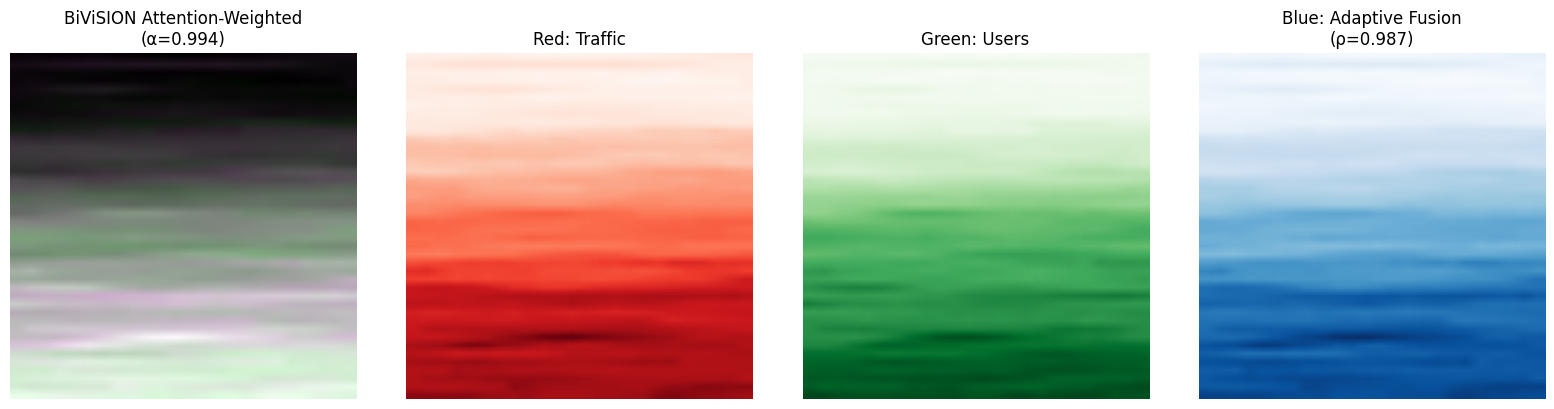

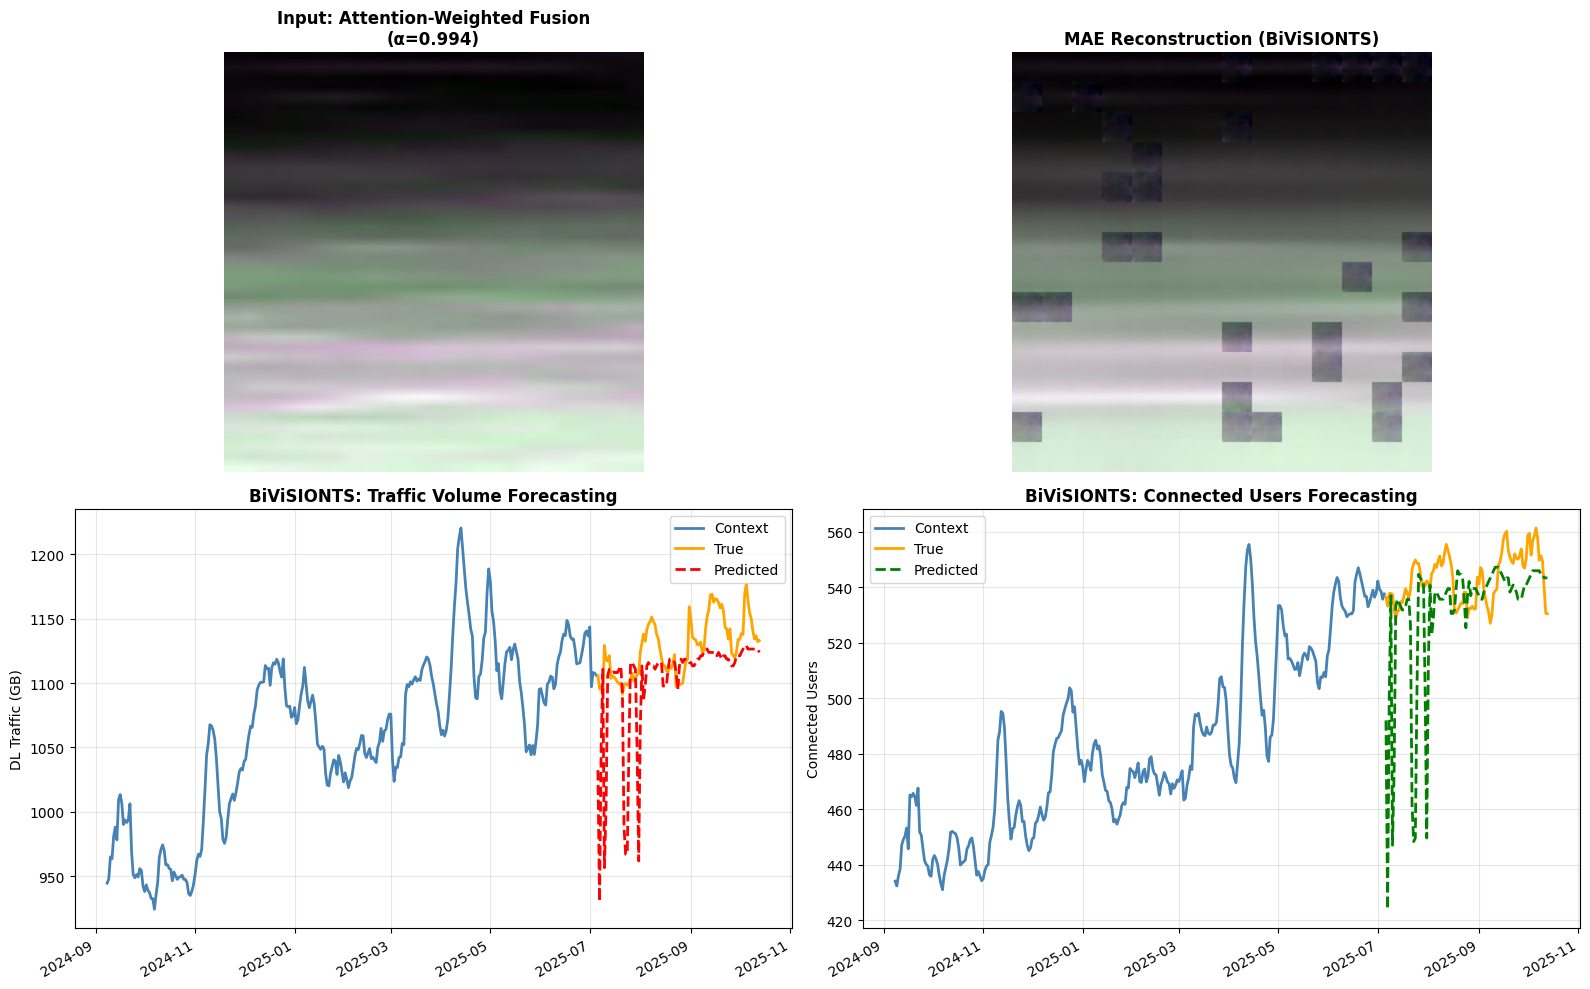

📊 BiViSIONTS Evaluation - Section 2 (Attention-Weighted Fusion)

🎯 Attention Parameters:
  Correlation (ρ) = 0.9871
  Attention weight (α) = 0.9935

🔴 DL Traffic Volume:
  MSE  = 2019.5063
  MAE  = 29.0821
  RMSE = 44.9389
  ✅ Success Rate (±10%): 93.00%

🟢 Connected Users:
  MSE  = 768.1643
  MAE  = 16.3772
  RMSE = 27.7158
  ✅ Success Rate (±10%): 93.00%


In [171]:
# Load VisionTS model
from visionts import VisionTS

model = VisionTS('mae_base', './ckpt/').to(DEVICE)
model.update_config(
    context_len=CONTEXT_LEN,
    pred_len=PRED_LEN,
    align_const=1,
    norm_const=1,
    periodicity=24
)
model.eval()

# Use MAE model directly for RGB processing
from visionts.models_mae import MaskedAutoencoderViT

mae_model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
mae_model.load_state_dict(ckpt['model'], strict=False)
mae_model.eval()
mae_model.to(DEVICE)

# Create bivariate attention-weighted image from FULL series (context + forecast)
full_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
full_users = data_users[:CONTEXT_LEN + PRED_LEN]

# Attention-weighted encoding function
def bivariate_attention_weighted_v2(series1, series2, periodicity=24):
    """
    BiViSION Attention-Weighted Fusion - matches Section 1
    """
    total_len = len(series1)
    # Truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization later
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Compute global correlation coefficient
    corr = np.corrcoef(series1[:usable_len], series2[:usable_len])[0, 1]
    # Normalize correlation to [0, 1] range for alpha weight
    alpha = (corr + 1) / 2  # Maps [-1, 1] to [0, 1]
    
    print(f"📊 Correlation: {corr:.4f}, Attention α: {alpha:.4f}")
    
    # Create blue channel as correlation-weighted adaptive fusion
    matrix_fusion = alpha * matrix1_norm + (1 - alpha) * matrix2_norm
    
    # Convert to uint8 [0, 255]
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    # Stack into RGB image
    height, width = r_channel.shape
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and normalization parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len,
        'alpha': alpha,
        'correlation': corr
    }
    
    return img, norm_params

# Create input image from full series
input_img_full, norm_params_full = bivariate_attention_weighted_v2(full_traffic, full_users)

# Visualize the encoding
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(input_img_full)
plt.title(f"BiViSION Attention-Weighted\n(α={norm_params_full['alpha']:.3f})")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(np.array(input_img_full)[:, :, 0], cmap='Reds')
plt.title("Red: Traffic")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(np.array(input_img_full)[:, :, 1], cmap='Greens')
plt.title("Green: Users")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(np.array(input_img_full)[:, :, 2], cmap='Blues')
plt.title(f"Blue: Adaptive Fusion\n(ρ={norm_params_full['correlation']:.3f})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Convert RGB image to tensor
x_tensor = ToTensor()(input_img_full).unsqueeze(0).to(DEVICE)

# Run forward pass through MAE
with torch.no_grad():
    latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=0.85)
    pred = mae_model.forward_decoder(latent, ids_restore)
    recon_tensor = mae_model.unpatchify(pred)

# Convert reconstruction back to image
recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
recon_img = Image.fromarray(recon_rgb, mode='RGB')

# Decode both variables from reconstruction
def attention_weighted_to_bivariate_v2(img, norm_params, periodicity=24):
    """
    Decode attention-weighted RGB image back to two time series
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Extract channels
    r_channel = img_array[:, :, 0]  # Traffic
    g_channel = img_array[:, :, 1]  # Users
    
    # Flatten
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

# Decode reconstructed image
recon_traffic_full, recon_users_full = attention_weighted_to_bivariate_v2(recon_img, norm_params_full)

# Extract forecast portions (last PRED_LEN points)
forecast_traffic = recon_traffic_full[-PRED_LEN:]
forecast_users = recon_users_full[-PRED_LEN:]

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Images
axes[0, 0].imshow(input_img_full)
axes[0, 0].set_title(f"Input: Attention-Weighted Fusion\n(α={norm_params_full['alpha']:.3f})", 
                     fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(recon_img)
axes[0, 1].set_title("MAE Reconstruction (BiViSIONTS)", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Traffic forecast
timestamps = pd.to_datetime(df['date'])
time_x = timestamps[:CONTEXT_LEN]
time_y = timestamps[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

axes[1, 0].plot(time_x[-PLOT_CONTEXT_LEN:], x_traffic[-PLOT_CONTEXT_LEN:], 
                label="Context", color='steelblue', linewidth=2)
axes[1, 0].plot(time_y, y_traffic, label="True", color='orange', linewidth=2)
axes[1, 0].plot(time_y, forecast_traffic, label="Predicted", 
                color='red', linewidth=2, linestyle='--')
axes[1, 0].set_title("BiViSIONTS: Traffic Volume Forecasting", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("DL Traffic (GB)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Users forecast
axes[1, 1].plot(time_x[-PLOT_CONTEXT_LEN:], x_users[-PLOT_CONTEXT_LEN:], 
                label="Context", color='steelblue', linewidth=2)
axes[1, 1].plot(time_y, y_users, label="True", color='orange', linewidth=2)
axes[1, 1].plot(time_y, forecast_users, label="Predicted", 
                color='green', linewidth=2, linestyle='--')
axes[1, 1].set_title("BiViSIONTS: Connected Users Forecasting", fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel("Connected Users")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Traffic metrics
mse_traffic = mean_squared_error(y_traffic, forecast_traffic)
mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
rmse_traffic = np.sqrt(mse_traffic)
success_traffic = (np.abs(forecast_traffic - y_traffic) <= 0.10 * np.abs(y_traffic)).sum() / len(y_traffic)

# Users metrics
mse_users = mean_squared_error(y_users, forecast_users)
mae_users = mean_absolute_error(y_users, forecast_users)
rmse_users = np.sqrt(mse_users)
success_users = (np.abs(forecast_users - y_users) <= 0.10 * np.abs(y_users)).sum() / len(y_users)

# Print results
print("=" * 80)
print("📊 BiViSIONTS Evaluation - Section 2 (Attention-Weighted Fusion)")
print("=" * 80)
print(f"\n🎯 Attention Parameters:")
print(f"  Correlation (ρ) = {norm_params_full['correlation']:.4f}")
print(f"  Attention weight (α) = {norm_params_full['alpha']:.4f}")

print(f"\n🔴 DL Traffic Volume:")
print(f"  MSE  = {mse_traffic:.4f}")
print(f"  MAE  = {mae_traffic:.4f}")
print(f"  RMSE = {rmse_traffic:.4f}")
print(f"  ✅ Success Rate (±10%): {success_traffic * 100:.2f}%")

print(f"\n🟢 Connected Users:")
print(f"  MSE  = {mse_users:.4f}")
print(f"  MAE  = {mae_users:.4f}")
print(f"  RMSE = {rmse_users:.4f}")
print(f"  ✅ Success Rate (±10%): {success_users * 100:.2f}%")
print("=" * 80)

🔄 Running BiViSIONTS (Attention-Weighted) 1000 iterations for convergence analysis...
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
✓ Completed 10/1000 iterations
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
📊 Correlation: 0.9894, Attention α: 0.9947
✓ Completed 20/1000 ite

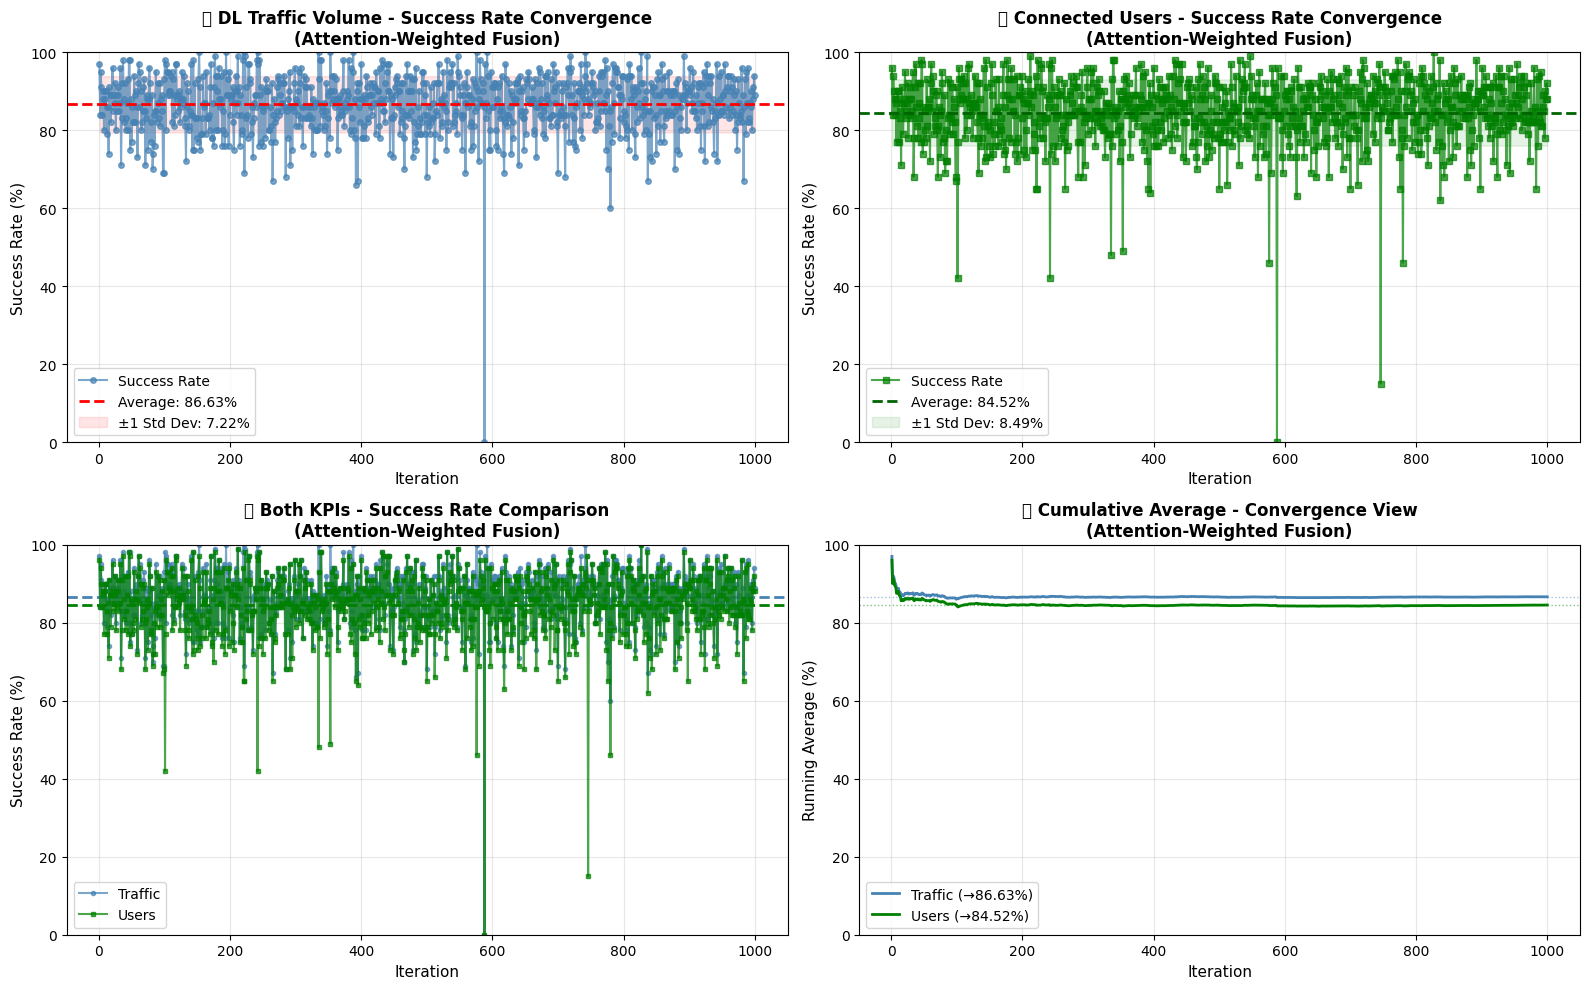

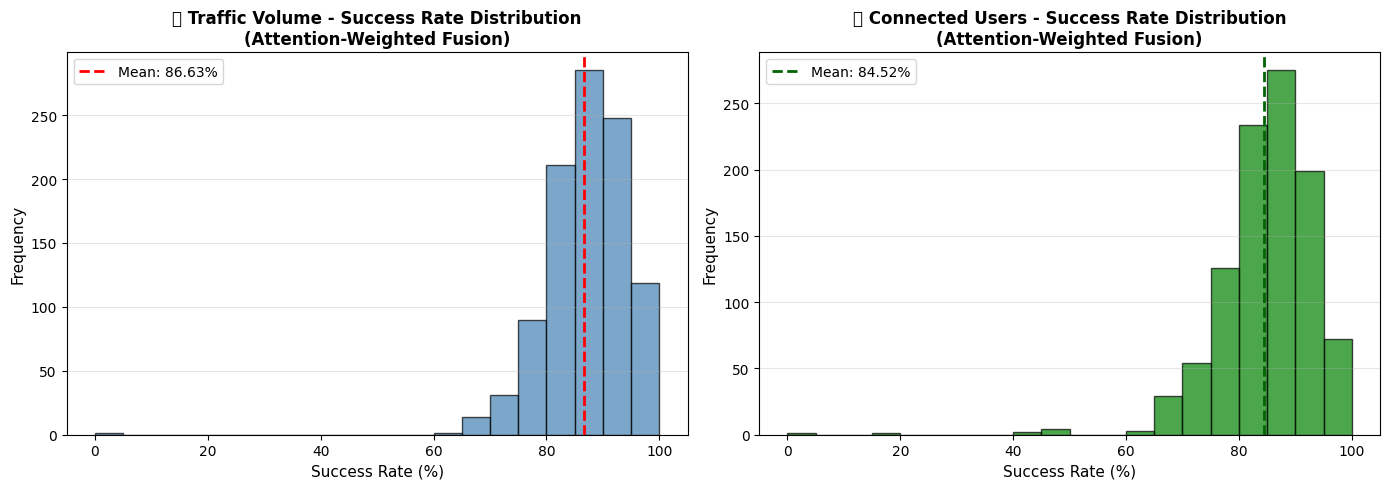


📋 Results DataFrame (First 10 rows):
   Iteration  Traffic_Success_Rate_%  Users_Success_Rate_%  Traffic_MSE  \
0          1                    97.0                  96.0  1338.772067   
1          2                    84.0                  84.0  5104.349382   
2          3                    95.0                  94.0  2255.692402   
3          4                    91.0                  90.0  3668.094584   
4          5                    84.0                  84.0  5664.864805   
5          6                    90.0                  88.0  3873.405625   
6          7                    88.0                  87.0  3949.467702   
7          8                    80.0                  77.0  6483.502279   
8          9                    88.0                  88.0  3979.132969   
9         10                    90.0                  90.0  3348.684601   

   Traffic_MAE    Users_MSE  Users_MAE  
0    24.000955   502.940118  16.952606  
1    41.078778  1641.446638  24.784280  
2    26.50508

In [207]:
# Multi-iteration Convergence Analysis for BiViSIONTS (Attention-Weighted Fusion)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

# Configuration
NUM_ITERATIONS = 1000  # Number of times to run the test
MASK_RATIO = 0.85   # Mask ratio used in MAE

print(f"🔄 Running BiViSIONTS (Attention-Weighted) {NUM_ITERATIONS} iterations for convergence analysis...")
print("=" * 80)

# Storage for results
traffic_success_rates = []
users_success_rates = []
traffic_mse_list = []
traffic_mae_list = []
users_mse_list = []
users_mae_list = []

# Run multiple iterations
for iteration in range(NUM_ITERATIONS):
    # Set different random seed for each iteration to get different mask patterns
    seed = 42 + iteration
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Create input image (same data, different reconstruction due to random masking)
    input_img_full, norm_params_full = bivariate_attention_weighted_v2(full_traffic, full_users)
    
    # Convert to tensor
    x_tensor = ToTensor()(input_img_full).unsqueeze(0).to(DEVICE)
    
    # Run forward pass through MAE with random masking
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=MASK_RATIO)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    # Convert reconstruction back to image
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode both variables
    recon_traffic_full, recon_users_full = attention_weighted_to_bivariate_v2(recon_img, norm_params_full)
    
    # Extract forecast portions
    forecast_traffic = recon_traffic_full[-PRED_LEN:]
    forecast_users = recon_users_full[-PRED_LEN:]
    
    # Calculate metrics for Traffic
    mse_traffic = mean_squared_error(y_traffic, forecast_traffic)
    mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
    success_traffic = (np.abs(forecast_traffic - y_traffic) <= 0.10 * np.abs(y_traffic)).sum() / len(y_traffic)
    
    # Calculate metrics for Users
    mse_users = mean_squared_error(y_users, forecast_users)
    mae_users = mean_absolute_error(y_users, forecast_users)
    success_users = (np.abs(forecast_users - y_users) <= 0.10 * np.abs(y_users)).sum() / len(y_users)
    
    # Store results
    traffic_success_rates.append(success_traffic * 100)
    users_success_rates.append(success_users * 100)
    traffic_mse_list.append(mse_traffic)
    traffic_mae_list.append(mae_traffic)
    users_mse_list.append(mse_users)
    users_mae_list.append(mae_users)
    
    # Print progress every 10 iterations
    if (iteration + 1) % 10 == 0:
        print(f"✓ Completed {iteration + 1}/{NUM_ITERATIONS} iterations")

print("=" * 80)
print("✅ All iterations completed!")
print()

# Calculate statistics
traffic_avg = np.mean(traffic_success_rates)
traffic_std = np.std(traffic_success_rates)
users_avg = np.mean(users_success_rates)
users_std = np.std(users_success_rates)

print("📊 CONVERGENCE STATISTICS (Attention-Weighted Fusion)")
print("=" * 80)
print(f"\n🎯 Encoding Method: Attention-Weighted Fusion")
print(f"  Correlation (ρ) = {norm_params_full['correlation']:.4f}")
print(f"  Attention weight (α) = {norm_params_full['alpha']:.4f}")

print(f"\n🔴 DL Traffic Volume:")
print(f"  Average Success Rate: {traffic_avg:.2f}%")
print(f"  Std Deviation: {traffic_std:.2f}%")
print(f"  Min: {min(traffic_success_rates):.2f}%")
print(f"  Max: {max(traffic_success_rates):.2f}%")
print(f"  Average MSE: {np.mean(traffic_mse_list):.4f}")
print(f"  Average MAE: {np.mean(traffic_mae_list):.4f}")

print(f"\n🟢 Connected Users:")
print(f"  Average Success Rate: {users_avg:.2f}%")
print(f"  Std Deviation: {users_std:.2f}%")
print(f"  Min: {min(users_success_rates):.2f}%")
print(f"  Max: {max(users_success_rates):.2f}%")
print(f"  Average MSE: {np.mean(users_mse_list):.4f}")
print(f"  Average MAE: {np.mean(users_mae_list):.4f}")
print("=" * 80)

# Visualization: Success Rate Convergence
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

iterations = list(range(1, NUM_ITERATIONS + 1))

# Plot 1: Traffic Success Rate with Average Line
axes[0, 0].plot(iterations, traffic_success_rates, marker='o', markersize=4, 
                linewidth=1.5, color='steelblue', alpha=0.7, label='Success Rate')
axes[0, 0].axhline(y=traffic_avg, color='red', linestyle='--', linewidth=2, 
                   label=f'Average: {traffic_avg:.2f}%')
axes[0, 0].fill_between(iterations, traffic_avg - traffic_std, traffic_avg + traffic_std, 
                        color='red', alpha=0.1, label=f'±1 Std Dev: {traffic_std:.2f}%')
axes[0, 0].set_xlabel('Iteration', fontsize=11)
axes[0, 0].set_ylabel('Success Rate (%)', fontsize=11)
axes[0, 0].set_title('🔴 DL Traffic Volume - Success Rate Convergence\n(Attention-Weighted Fusion)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 100])

# Plot 2: Users Success Rate with Average Line
axes[0, 1].plot(iterations, users_success_rates, marker='s', markersize=4, 
                linewidth=1.5, color='green', alpha=0.7, label='Success Rate')
axes[0, 1].axhline(y=users_avg, color='darkgreen', linestyle='--', linewidth=2, 
                   label=f'Average: {users_avg:.2f}%')
axes[0, 1].fill_between(iterations, users_avg - users_std, users_avg + users_std, 
                        color='green', alpha=0.1, label=f'±1 Std Dev: {users_std:.2f}%')
axes[0, 1].set_xlabel('Iteration', fontsize=11)
axes[0, 1].set_ylabel('Success Rate (%)', fontsize=11)
axes[0, 1].set_title('🟢 Connected Users - Success Rate Convergence\n(Attention-Weighted Fusion)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 100])

# Plot 3: Combined Success Rates
axes[1, 0].plot(iterations, traffic_success_rates, marker='o', markersize=3, 
                linewidth=1.5, color='steelblue', alpha=0.7, label='Traffic')
axes[1, 0].axhline(y=traffic_avg, color='steelblue', linestyle='--', linewidth=2)
axes[1, 0].plot(iterations, users_success_rates, marker='s', markersize=3, 
                linewidth=1.5, color='green', alpha=0.7, label='Users')
axes[1, 0].axhline(y=users_avg, color='green', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Iteration', fontsize=11)
axes[1, 0].set_ylabel('Success Rate (%)', fontsize=11)
axes[1, 0].set_title('📊 Both KPIs - Success Rate Comparison\n(Attention-Weighted Fusion)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='best')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 100])

# Plot 4: Running Average (Cumulative Mean)
traffic_running_avg = [np.mean(traffic_success_rates[:i+1]) for i in range(NUM_ITERATIONS)]
users_running_avg = [np.mean(users_success_rates[:i+1]) for i in range(NUM_ITERATIONS)]

axes[1, 1].plot(iterations, traffic_running_avg, linewidth=2, 
                color='steelblue', label=f'Traffic (→{traffic_avg:.2f}%)')
axes[1, 1].plot(iterations, users_running_avg, linewidth=2, 
                color='green', label=f'Users (→{users_avg:.2f}%)')
axes[1, 1].axhline(y=traffic_avg, color='steelblue', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 1].axhline(y=users_avg, color='green', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Iteration', fontsize=11)
axes[1, 1].set_ylabel('Running Average (%)', fontsize=11)
axes[1, 1].set_title('📈 Cumulative Average - Convergence View\n(Attention-Weighted Fusion)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Additional: Distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(traffic_success_rates, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=traffic_avg, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {traffic_avg:.2f}%')
axes[0].set_xlabel('Success Rate (%)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('🔴 Traffic Volume - Success Rate Distribution\n(Attention-Weighted Fusion)', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].hist(users_success_rates, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(x=users_avg, color='darkgreen', linestyle='--', linewidth=2, 
                label=f'Mean: {users_avg:.2f}%')
axes[1].set_xlabel('Success Rate (%)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('🟢 Connected Users - Success Rate Distribution\n(Attention-Weighted Fusion)', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Save results to DataFrame
results_df = pd.DataFrame({
    'Iteration': iterations,
    'Traffic_Success_Rate_%': traffic_success_rates,
    'Users_Success_Rate_%': users_success_rates,
    'Traffic_MSE': traffic_mse_list,
    'Traffic_MAE': traffic_mae_list,
    'Users_MSE': users_mse_list,
    'Users_MAE': users_mae_list
})

print("\n📋 Results DataFrame (First 10 rows):")
print(results_df.head(10))

# Summary statistics
print("\n📊 SUMMARY STATISTICS (Attention-Weighted Fusion)")
print("=" * 80)
print(results_df.describe())
print("=" * 80)

## Complex Representation

## Section 1: MAE Model with Complex Representation


In [176]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from visionts import VisionTS
from visionts.models_mae import MaskedAutoencoderViT
from torchvision.transforms import ToTensor
from PIL import Image
import os
from timm.models.vision_transformer import PatchEmbed, Block
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✅ Random seed set for reproducible results")

✅ Random seed set for reproducible results


In [177]:
# STEP 0: Configurable forecast length
PRED_LEN = 100  # 👈 CHANGE THIS ONLY

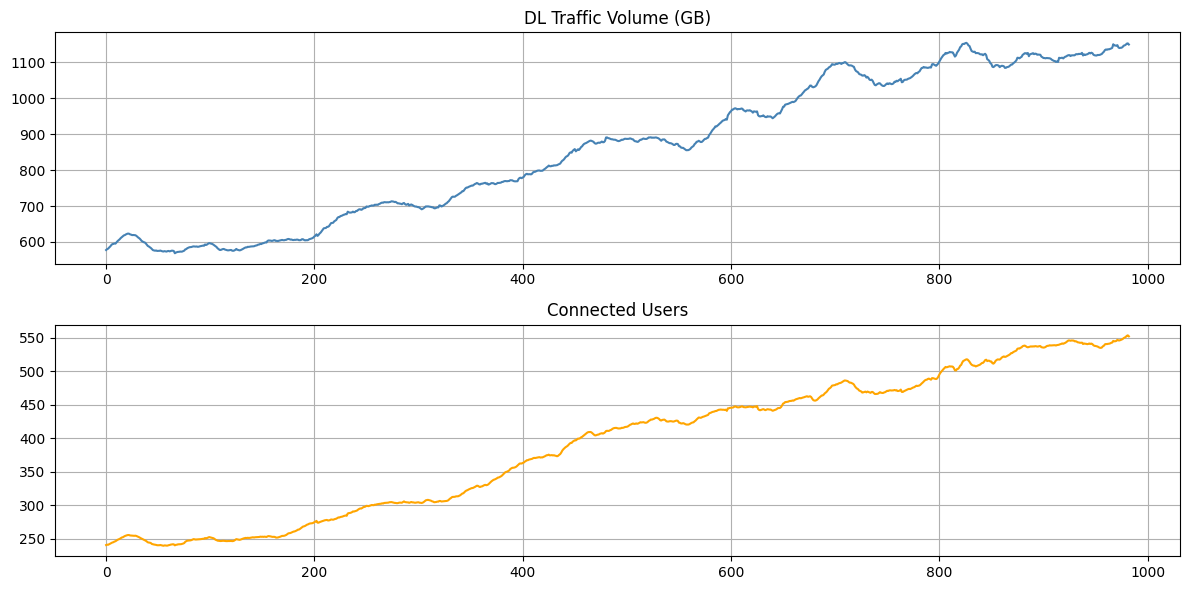

In [178]:
# Step 2: Load from CSV - BIVARIATE DATA

df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')

CONTEXT_LEN = len(df) - PRED_LEN

# Extract both variables (bivariate)
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]
data_users = df['connected_users'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]

# Plot both variables
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(data_traffic, color='steelblue')
axs[0].set_title("DL Traffic Volume (GB)")
axs[0].grid(True)

axs[1].plot(data_users, color='orange')
axs[1].set_title("Connected Users")
axs[1].grid(True)

plt.tight_layout()
plt.show()

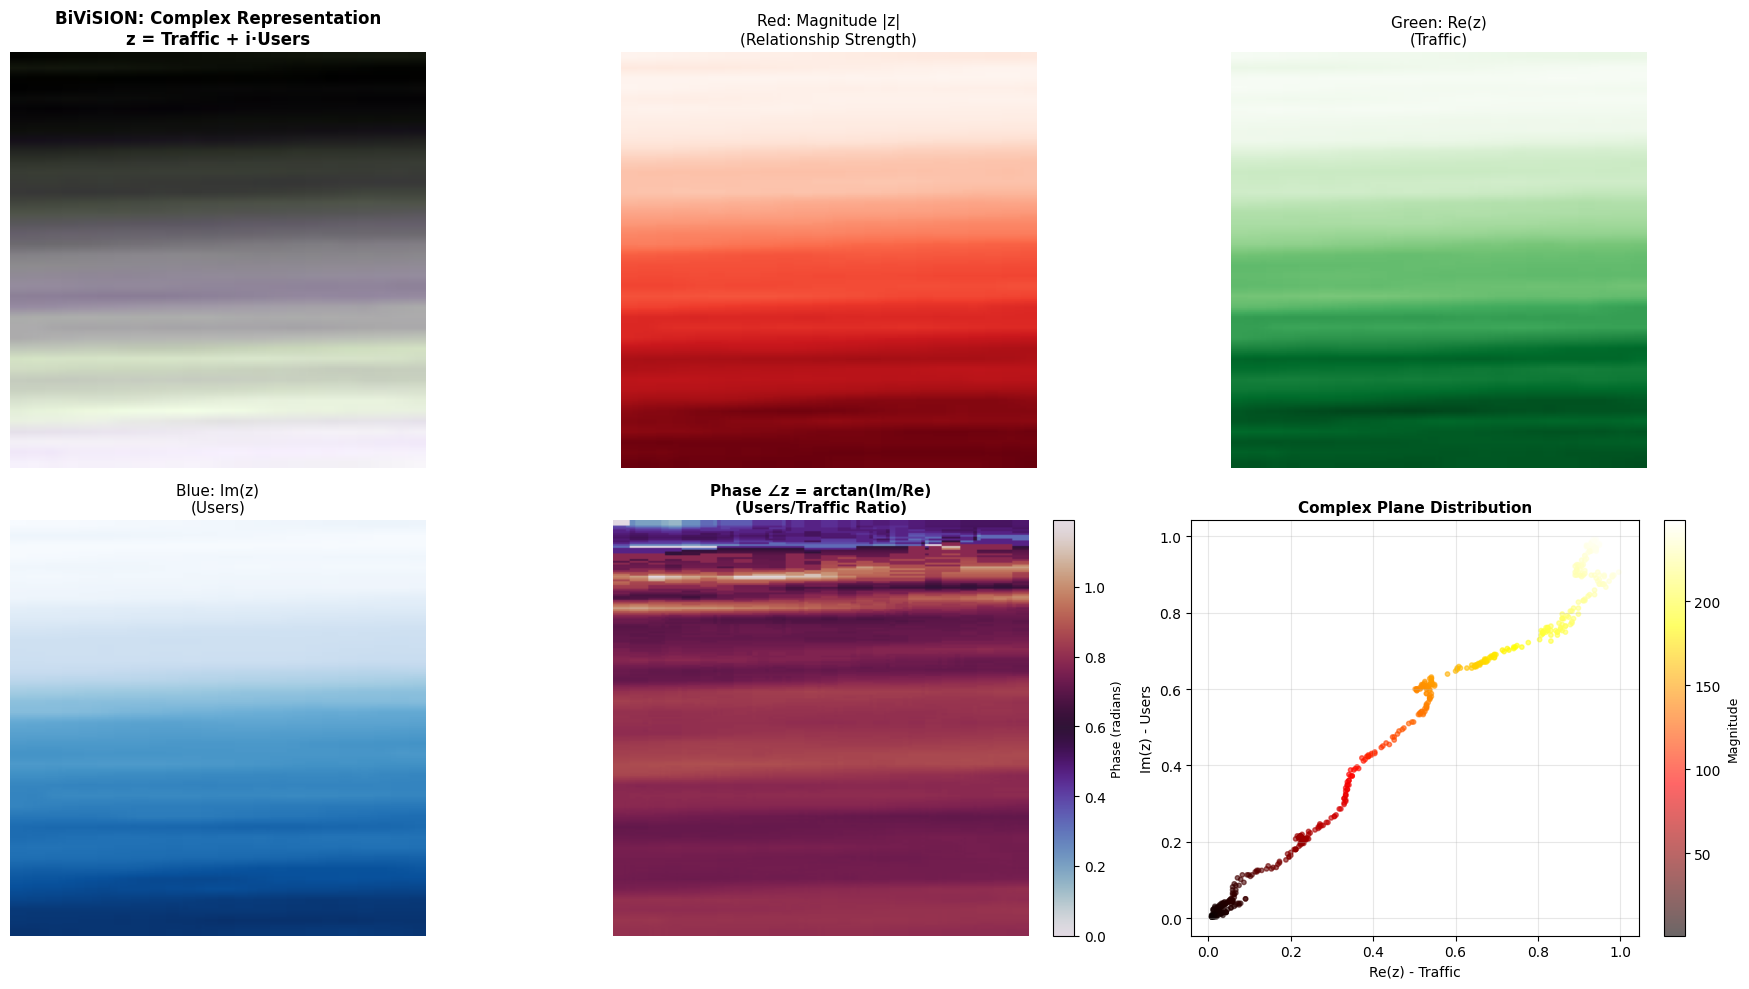

🔢 Complex Encoding:
  • z = Traffic + i·Users
  • Red (R) = |z| = √(Traffic² + Users²)
  • Green (G) = Re(z) = Traffic
  • Blue (B) = Im(z) = Users
  • Phase = arctan(Users/Traffic)


In [179]:
# Step 3: Convert BIVARIATE time series to RGB using Complex Representation
def bivariate_complex_to_image(series1, series2, context_len, pred_len, periodicity=24):
    """
    BiViSION Complex Representation Method:
    Treat bivariate time series as complex numbers: z = series1 + i*series2
    
    Encoding scheme:
    - Red Channel: Magnitude |z| = sqrt(series1² + series2²)
    - Green Channel: Real part (series1)
    - Blue Channel: Imaginary part (series2)
    
    This preserves:
    - Individual values in G and B channels
    - Relationship strength in R channel (magnitude)
    - Phase information implicit in R/G/B combination
    """
    total_len = context_len + pred_len
    # Truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization later
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Create complex representation: z = real + i*imag
    complex_matrix = matrix1_norm + 1j * matrix2_norm
    
    # Extract complex features
    magnitude = np.abs(complex_matrix)  # |z| = sqrt(real² + imag²)
    # Normalize magnitude to [0, 1]
    magnitude = magnitude / np.sqrt(2)  # Max magnitude is sqrt(2) when both are 1
    magnitude = np.clip(magnitude, 0, 1)
    
    # RGB Encoding:
    # R: Magnitude (relationship strength)
    # G: Real part (Traffic)
    # B: Imaginary part (Users)
    r_channel = (magnitude * 255).astype(np.uint8)
    g_channel = (matrix1_norm * 255).astype(np.uint8)
    b_channel = (matrix2_norm * 255).astype(np.uint8)
    
    # Stack into RGB image
    height, width = r_channel.shape
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and normalization parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len
    }
    
    return img, norm_params

img, norm_params = bivariate_complex_to_image(data_traffic, data_users, CONTEXT_LEN, PRED_LEN)

# Visualize the Complex representation
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Full RGB
axes[0, 0].imshow(img)
axes[0, 0].set_title("BiViSION: Complex Representation\nz = Traffic + i·Users", 
                     fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Individual channels
img_array = np.array(img)
axes[0, 1].imshow(img_array[:, :, 0], cmap='Reds')
axes[0, 1].set_title("Red: Magnitude |z|\n(Relationship Strength)", fontsize=11)
axes[0, 1].axis('off')

axes[0, 2].imshow(img_array[:, :, 1], cmap='Greens')
axes[0, 2].set_title("Green: Re(z)\n(Traffic)", fontsize=11)
axes[0, 2].axis('off')

axes[1, 0].imshow(img_array[:, :, 2], cmap='Blues')
axes[1, 0].set_title("Blue: Im(z)\n(Users)", fontsize=11)
axes[1, 0].axis('off')

# Show phase (angle) of complex number
phase = np.arctan2(img_array[:, :, 2] / 255.0, img_array[:, :, 1] / 255.0)
axes[1, 1].imshow(phase, cmap='twilight')
axes[1, 1].set_title("Phase ∠z = arctan(Im/Re)\n(Users/Traffic Ratio)", fontsize=11, fontweight='bold')
axes[1, 1].axis('off')
cbar1 = plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1], fraction=0.046)
cbar1.set_label('Phase (radians)', fontsize=9)

# Show complex plane representation (scatter plot)
# Downsample for visualization
sample_indices = np.random.choice(img_array[:, :, 1].size, size=500, replace=False)
real_samples = (img_array[:, :, 1].flatten()[sample_indices] / 255.0)
imag_samples = (img_array[:, :, 2].flatten()[sample_indices] / 255.0)
axes[1, 2].scatter(real_samples, imag_samples, c=img_array[:, :, 0].flatten()[sample_indices], 
                   cmap='hot', alpha=0.6, s=10)
axes[1, 2].set_xlabel('Re(z) - Traffic', fontsize=10)
axes[1, 2].set_ylabel('Im(z) - Users', fontsize=10)
axes[1, 2].set_title("Complex Plane Distribution", fontsize=11, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
cbar2 = plt.colorbar(axes[1, 2].collections[0], ax=axes[1, 2], fraction=0.046)
cbar2.set_label('Magnitude', fontsize=9)

plt.tight_layout()
plt.show()

print("🔢 Complex Encoding:")
print("  • z = Traffic + i·Users")
print("  • Red (R) = |z| = √(Traffic² + Users²)")
print("  • Green (G) = Re(z) = Traffic")
print("  • Blue (B) = Im(z) = Users")
print("  • Phase = arctan(Users/Traffic)")

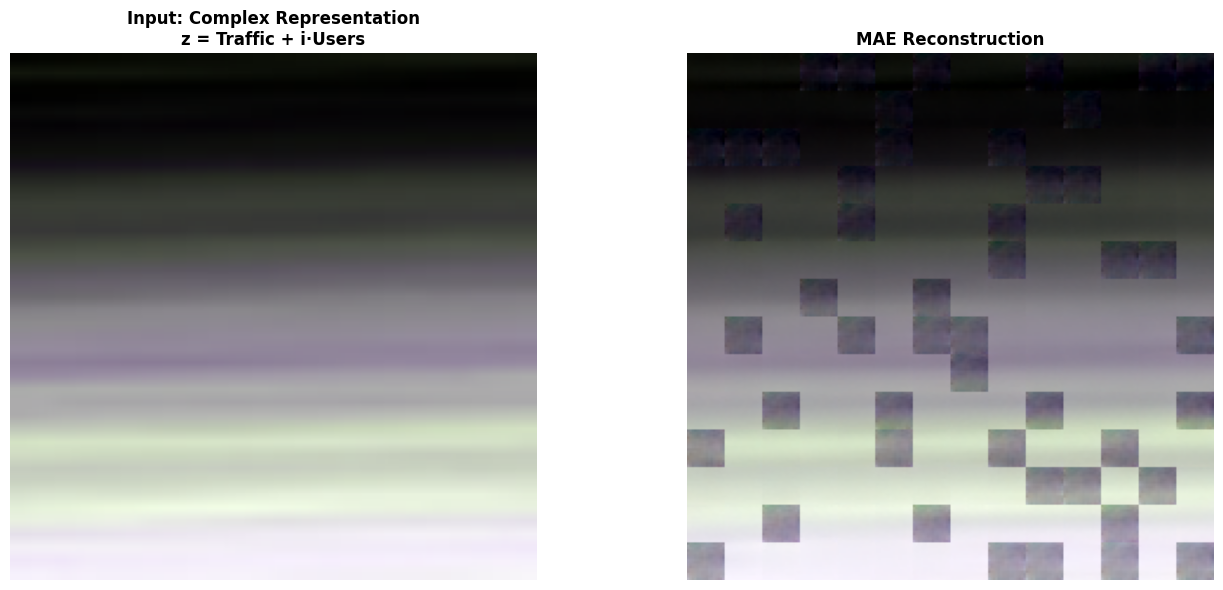

In [180]:
# Step 4: Run MAE reconstruction on BIVARIATE Complex representation
model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model'], strict=False)
model.eval()

x = ToTensor()(img).unsqueeze(0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(x, mask_ratio=0.75)
    pred = model.forward_decoder(latent, ids_restore)
    output = model.unpatchify(pred).squeeze().permute(1, 2, 0).numpy()

output = np.clip(output * 255, 0, 255).astype(np.uint8)
reconstructed_img = Image.fromarray(output, mode='RGB')

# Visualize reconstruction
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(img)
axes[0].set_title("Input: Complex Representation\nz = Traffic + i·Users", 
                 fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(reconstructed_img)
axes[1].set_title("MAE Reconstruction", fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

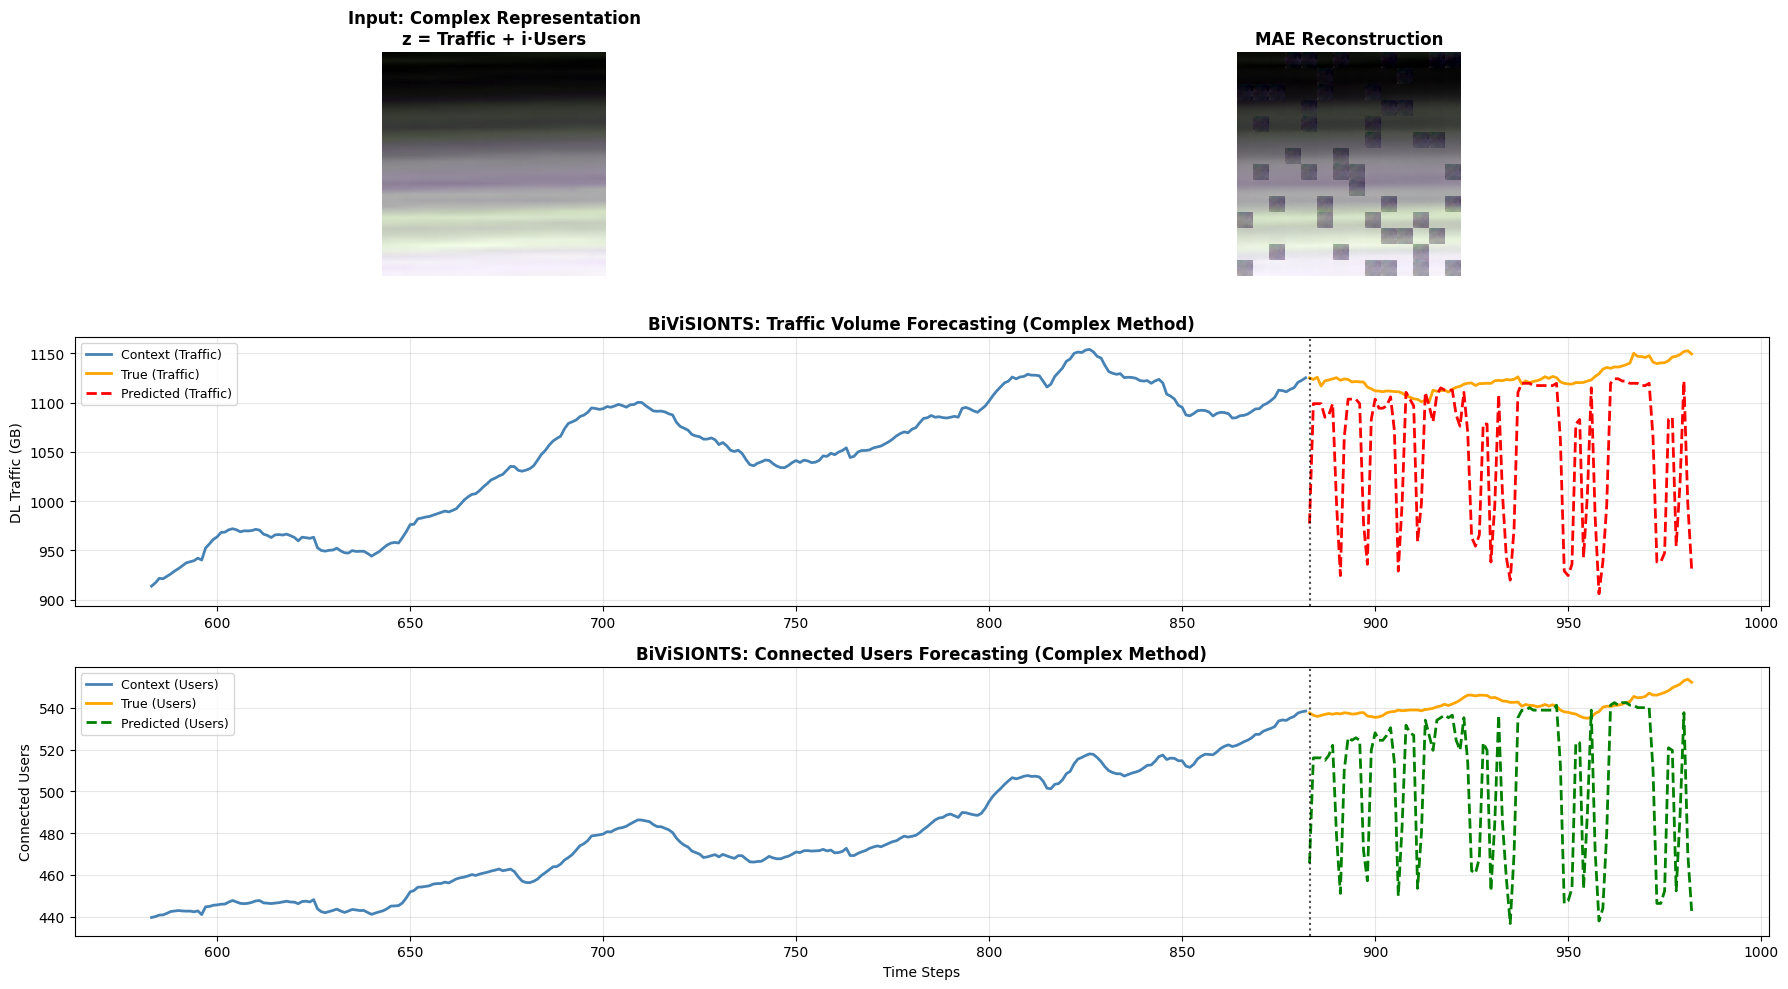

📊 BiViSIONTS Evaluation - MAE Model (Complex Representation)

🔢 Complex Number Representation:
  • z = Traffic + i·Users
  • Magnitude encodes relationship strength
  • Phase encodes relative proportions

🔴 DL Traffic Volume (Real Part):
  MSE  = 10153.6485
  MAE  = 70.2574
  RMSE = 100.7653
  ✅ Success Rate (±10%): 67.00%

🟢 Connected Users (Imaginary Part):
  MSE  = 2430.4259
  MAE  = 34.7931
  RMSE = 49.2993
  ✅ Success Rate (±10%): 67.00%


In [184]:
PLOT_CONTEXT_LEN = 300  # 👈 Only change this to zoom in or out

# Step 5: Decode BIVARIATE forecasts from reconstructed Complex image
def complex_image_to_bivariate(img, norm_params, periodicity=24):
    """
    Decode Complex representation RGB image back to two time series
    
    Direct extraction:
    - Green channel → Real part → Traffic (series1)
    - Blue channel → Imaginary part → Users (series2)
    - Red channel (magnitude) provides validation/consistency check
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Direct extraction from channels
    # Green = Real part = Traffic
    # Blue = Imaginary part = Users
    g_channel = img_array[:, :, 1]  # Real part (Traffic)
    b_channel = img_array[:, :, 2]  # Imaginary part (Users)
    
    # Flatten
    series1_norm = g_channel.flatten()
    series2_norm = b_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

# Decode reconstructed image
recon_traffic, recon_users = complex_image_to_bivariate(reconstructed_img, norm_params)

# Extract forecast portions
forecast_traffic = recon_traffic[-PRED_LEN:]
forecast_users = recon_users[-PRED_LEN:]

# Ground truth
true_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
true_users = data_users[:CONTEXT_LEN + PRED_LEN]

# --- Visualization ---
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1.2, 1.2])

# Row 1: Images
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img)
ax1.set_title("Input: Complex Representation\nz = Traffic + i·Users", 
              fontsize=12, fontweight='bold')
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(reconstructed_img)
ax2.set_title("MAE Reconstruction", fontsize=12, fontweight='bold')
ax2.axis("off")

# Row 2: Traffic forecasting
ax3 = fig.add_subplot(gs[1, :])
plot_start = max(0, CONTEXT_LEN - PLOT_CONTEXT_LEN)
ax3.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_traffic[plot_start:CONTEXT_LEN],
    label="Context (Traffic)", color="steelblue", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Traffic)", color="orange", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_traffic, label="Predicted (Traffic)", color="red", linewidth=2, linestyle='--'
)
ax3.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.set_title("BiViSIONTS: Traffic Volume Forecasting (Complex Method)", fontsize=12, fontweight='bold')
ax3.set_ylabel("DL Traffic (GB)", fontsize=10)
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# Row 3: Users forecasting
ax4 = fig.add_subplot(gs[2, :])
ax4.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_users[plot_start:CONTEXT_LEN],
    label="Context (Users)", color="steelblue", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Users)", color="orange", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_users, label="Predicted (Users)", color="green", linewidth=2, linestyle='--'
)
ax4.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax4.set_title("BiViSIONTS: Connected Users Forecasting (Complex Method)", fontsize=12, fontweight='bold')
ax4.set_xlabel("Time Steps", fontsize=10)
ax4.set_ylabel("Connected Users", fontsize=10)
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Evaluation Metrics ---
true_traffic_forecast = true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
true_users_forecast = true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Traffic metrics
mse_traffic = mean_squared_error(true_traffic_forecast, forecast_traffic)
mae_traffic = mean_absolute_error(true_traffic_forecast, forecast_traffic)
rmse_traffic = np.sqrt(mse_traffic)

# Users metrics
mse_users = mean_squared_error(true_users_forecast, forecast_users)
mae_users = mean_absolute_error(true_users_forecast, forecast_users)
rmse_users = np.sqrt(mse_users)

# Success rates (±10% tolerance)
tolerance = 0.10
success_traffic = (np.abs(forecast_traffic - true_traffic_forecast) <= tolerance * np.abs(true_traffic_forecast)).sum() / len(true_traffic_forecast)
success_users = (np.abs(forecast_users - true_users_forecast) <= tolerance * np.abs(true_users_forecast)).sum() / len(true_users_forecast)

# Print results
print("=" * 80)
print("📊 BiViSIONTS Evaluation - MAE Model (Complex Representation)")
print("=" * 80)
print(f"\n🔢 Complex Number Representation:")
print(f"  • z = Traffic + i·Users")
print(f"  • Magnitude encodes relationship strength")
print(f"  • Phase encodes relative proportions")

print(f"\n🔴 DL Traffic Volume (Real Part):")
print(f"  MSE  = {mse_traffic:.4f}")
print(f"  MAE  = {mae_traffic:.4f}")
print(f"  RMSE = {rmse_traffic:.4f}")
print(f"  ✅ Success Rate (±10%): {success_traffic * 100:.2f}%")

print(f"\n🟢 Connected Users (Imaginary Part):")
print(f"  MSE  = {mse_users:.4f}")
print(f"  MAE  = {mae_users:.4f}")
print(f"  RMSE = {rmse_users:.4f}")
print(f"  ✅ Success Rate (±10%): {success_users * 100:.2f}%")
print("=" * 80)

## Section 2: VisionTS Model with Complex Representation


In [188]:
# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✅ Random seed set for reproducible results")

✅ Random seed set for reproducible results


In [189]:
# CONFIG
PRED_LEN = 100
CONTEXT_LEN = len(df) - PRED_LEN
PLOT_CONTEXT_LEN = 300

DEVICE = 'cpu'  # or 'cuda:0'

# Load BIVARIATE data
df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()
data_users = df['connected_users'].values.squeeze()

# Split into context and forecast
x_traffic = data_traffic[:CONTEXT_LEN]
y_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

x_users = data_users[:CONTEXT_LEN]
y_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

print(f"Context length: {CONTEXT_LEN}")
print(f"Prediction length: {PRED_LEN}")
print(f"Traffic range: [{x_traffic.min():.2f}, {x_traffic.max():.2f}]")
print(f"Users range: [{x_users.min():.2f}, {x_users.max():.2f}]")

Context length: 883
Prediction length: 100
Traffic range: [568.59, 1153.98]
Users range: [239.62, 538.46]


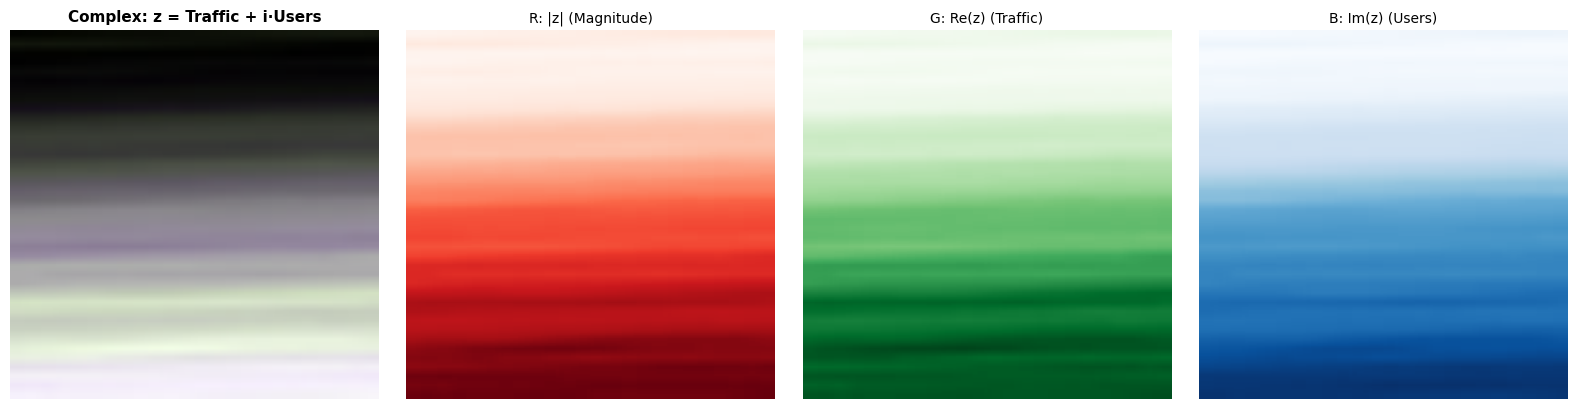

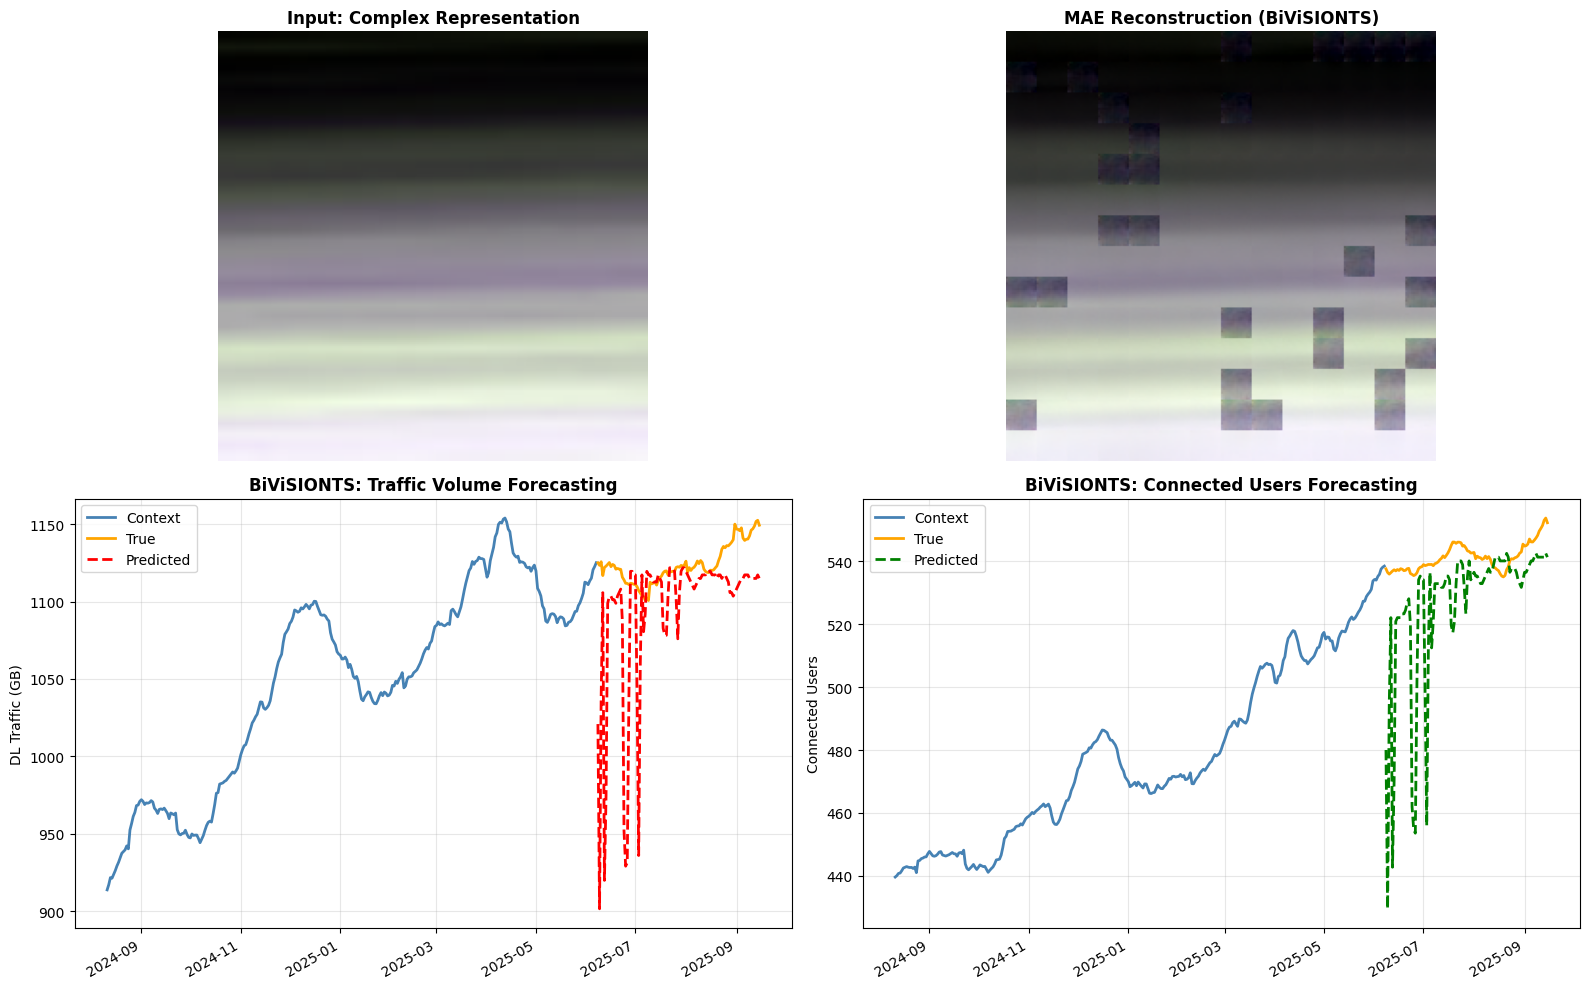

📊 BiViSIONTS Evaluation - Section 2 (Complex Representation)

🔢 Complex Number Representation:
  • z = Traffic + i·Users
  • |z| = Relationship strength
  • ∠z = Relative proportions

🔴 DL Traffic Volume (Real Part):
  MSE  = 3019.3468
  MAE  = 30.8475
  RMSE = 54.9486
  ✅ Success Rate (±10%): 93.00%

🟢 Connected Users (Imaginary Part):
  MSE  = 682.0906
  MAE  = 15.4886
  RMSE = 26.1169
  ✅ Success Rate (±10%): 92.00%


In [190]:
# Load VisionTS model
from visionts import VisionTS

model = VisionTS('mae_base', './ckpt/').to(DEVICE)
model.update_config(
    context_len=CONTEXT_LEN,
    pred_len=PRED_LEN,
    align_const=1,
    norm_const=1,
    periodicity=24
)
model.eval()

# Use MAE model directly for RGB processing
from visionts.models_mae import MaskedAutoencoderViT

mae_model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
mae_model.load_state_dict(ckpt['model'], strict=False)
mae_model.eval()
mae_model.to(DEVICE)

# Create bivariate Complex representation from FULL series (context + forecast)
full_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
full_users = data_users[:CONTEXT_LEN + PRED_LEN]

# Complex encoding function
def bivariate_complex_v2(series1, series2, periodicity=24):
    """
    BiViSION Complex Representation - matches Section 1
    z = series1 + i*series2
    """
    total_len = len(series1)
    # Truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization later
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Create complex representation
    complex_matrix = matrix1_norm + 1j * matrix2_norm
    
    # Extract magnitude
    magnitude = np.abs(complex_matrix)
    magnitude = magnitude / np.sqrt(2)  # Normalize
    magnitude = np.clip(magnitude, 0, 1)
    
    # RGB Encoding
    r_channel = (magnitude * 255).astype(np.uint8)
    g_channel = (matrix1_norm * 255).astype(np.uint8)
    b_channel = (matrix2_norm * 255).astype(np.uint8)
    
    # Stack into RGB image
    height, width = r_channel.shape
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and normalization parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len
    }
    
    return img, norm_params

# Create input image from full series
input_img_full, norm_params_full = bivariate_complex_v2(full_traffic, full_users)

# Visualize the encoding
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(input_img_full)
axes[0].set_title("Complex: z = Traffic + i·Users", fontsize=11, fontweight='bold')
axes[0].axis('off')

img_array_full = np.array(input_img_full)
axes[1].imshow(img_array_full[:, :, 0], cmap='Reds')
axes[1].set_title("R: |z| (Magnitude)", fontsize=10)
axes[1].axis('off')

axes[2].imshow(img_array_full[:, :, 1], cmap='Greens')
axes[2].set_title("G: Re(z) (Traffic)", fontsize=10)
axes[2].axis('off')

axes[3].imshow(img_array_full[:, :, 2], cmap='Blues')
axes[3].set_title("B: Im(z) (Users)", fontsize=10)
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Convert RGB image to tensor
x_tensor = ToTensor()(input_img_full).unsqueeze(0).to(DEVICE)

# Run forward pass through MAE
with torch.no_grad():
    latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=0.85)
    pred = mae_model.forward_decoder(latent, ids_restore)
    recon_tensor = mae_model.unpatchify(pred)

# Convert reconstruction back to image
recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
recon_img = Image.fromarray(recon_rgb, mode='RGB')

# Decode both variables from reconstruction
def complex_to_bivariate_v2(img, norm_params, periodicity=24):
    """
    Decode Complex representation - matches Section 1
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Direct extraction
    g_channel = img_array[:, :, 1]  # Real part (Traffic)
    b_channel = img_array[:, :, 2]  # Imaginary part (Users)
    
    # Flatten
    series1_norm = g_channel.flatten()
    series2_norm = b_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

# Decode reconstructed image
recon_traffic_full, recon_users_full = complex_to_bivariate_v2(recon_img, norm_params_full)

# Extract forecast portions (last PRED_LEN points)
forecast_traffic = recon_traffic_full[-PRED_LEN:]
forecast_users = recon_users_full[-PRED_LEN:]

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Images
axes[0, 0].imshow(input_img_full)
axes[0, 0].set_title("Input: Complex Representation", fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(recon_img)
axes[0, 1].set_title("MAE Reconstruction (BiViSIONTS)", fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Traffic forecast
timestamps = pd.to_datetime(df['date'])
time_x = timestamps[:CONTEXT_LEN]
time_y = timestamps[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

axes[1, 0].plot(time_x[-PLOT_CONTEXT_LEN:], x_traffic[-PLOT_CONTEXT_LEN:], 
                label="Context", color='steelblue', linewidth=2)
axes[1, 0].plot(time_y, y_traffic, label="True", color='orange', linewidth=2)
axes[1, 0].plot(time_y, forecast_traffic, label="Predicted", 
                color='red', linewidth=2, linestyle='--')
axes[1, 0].set_title("BiViSIONTS: Traffic Volume Forecasting", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("DL Traffic (GB)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Users forecast
axes[1, 1].plot(time_x[-PLOT_CONTEXT_LEN:], x_users[-PLOT_CONTEXT_LEN:], 
                label="Context", color='steelblue', linewidth=2)
axes[1, 1].plot(time_y, y_users, label="True", color='orange', linewidth=2)
axes[1, 1].plot(time_y, forecast_users, label="Predicted", 
                color='green', linewidth=2, linestyle='--')
axes[1, 1].set_title("BiViSIONTS: Connected Users Forecasting", fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel("Connected Users")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Traffic metrics
mse_traffic = mean_squared_error(y_traffic, forecast_traffic)
mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
rmse_traffic = np.sqrt(mse_traffic)
success_traffic = (np.abs(forecast_traffic - y_traffic) <= 0.10 * np.abs(y_traffic)).sum() / len(y_traffic)

# Users metrics
mse_users = mean_squared_error(y_users, forecast_users)
mae_users = mean_absolute_error(y_users, forecast_users)
rmse_users = np.sqrt(mse_users)
success_users = (np.abs(forecast_users - y_users) <= 0.10 * np.abs(y_users)).sum() / len(y_users)

# Print results
print("=" * 80)
print("📊 BiViSIONTS Evaluation - Section 2 (Complex Representation)")
print("=" * 80)
print(f"\n🔢 Complex Number Representation:")
print(f"  • z = Traffic + i·Users")
print(f"  • |z| = Relationship strength")
print(f"  • ∠z = Relative proportions")

print(f"\n🔴 DL Traffic Volume (Real Part):")
print(f"  MSE  = {mse_traffic:.4f}")
print(f"  MAE  = {mae_traffic:.4f}")
print(f"  RMSE = {rmse_traffic:.4f}")
print(f"  ✅ Success Rate (±10%): {success_traffic * 100:.2f}%")

print(f"\n🟢 Connected Users (Imaginary Part):")
print(f"  MSE  = {mse_users:.4f}")
print(f"  MAE  = {mae_users:.4f}")
print(f"  RMSE = {rmse_users:.4f}")
print(f"  ✅ Success Rate (±10%): {success_users * 100:.2f}%")
print("=" * 80)

🔄 Running BiViSIONTS 1000 iterations for convergence analysis...
✓ Completed 10/1000 iterations
✓ Completed 20/1000 iterations
✓ Completed 30/1000 iterations
✓ Completed 40/1000 iterations
✓ Completed 50/1000 iterations
✓ Completed 60/1000 iterations
✓ Completed 70/1000 iterations
✓ Completed 80/1000 iterations
✓ Completed 90/1000 iterations
✓ Completed 100/1000 iterations
✓ Completed 110/1000 iterations
✓ Completed 120/1000 iterations
✓ Completed 130/1000 iterations
✓ Completed 140/1000 iterations
✓ Completed 150/1000 iterations
✓ Completed 160/1000 iterations
✓ Completed 170/1000 iterations
✓ Completed 180/1000 iterations
✓ Completed 190/1000 iterations
✓ Completed 200/1000 iterations
✓ Completed 210/1000 iterations
✓ Completed 220/1000 iterations
✓ Completed 230/1000 iterations
✓ Completed 240/1000 iterations
✓ Completed 250/1000 iterations
✓ Completed 260/1000 iterations
✓ Completed 270/1000 iterations
✓ Completed 280/1000 iterations
✓ Completed 290/1000 iterations
✓ Completed 300/

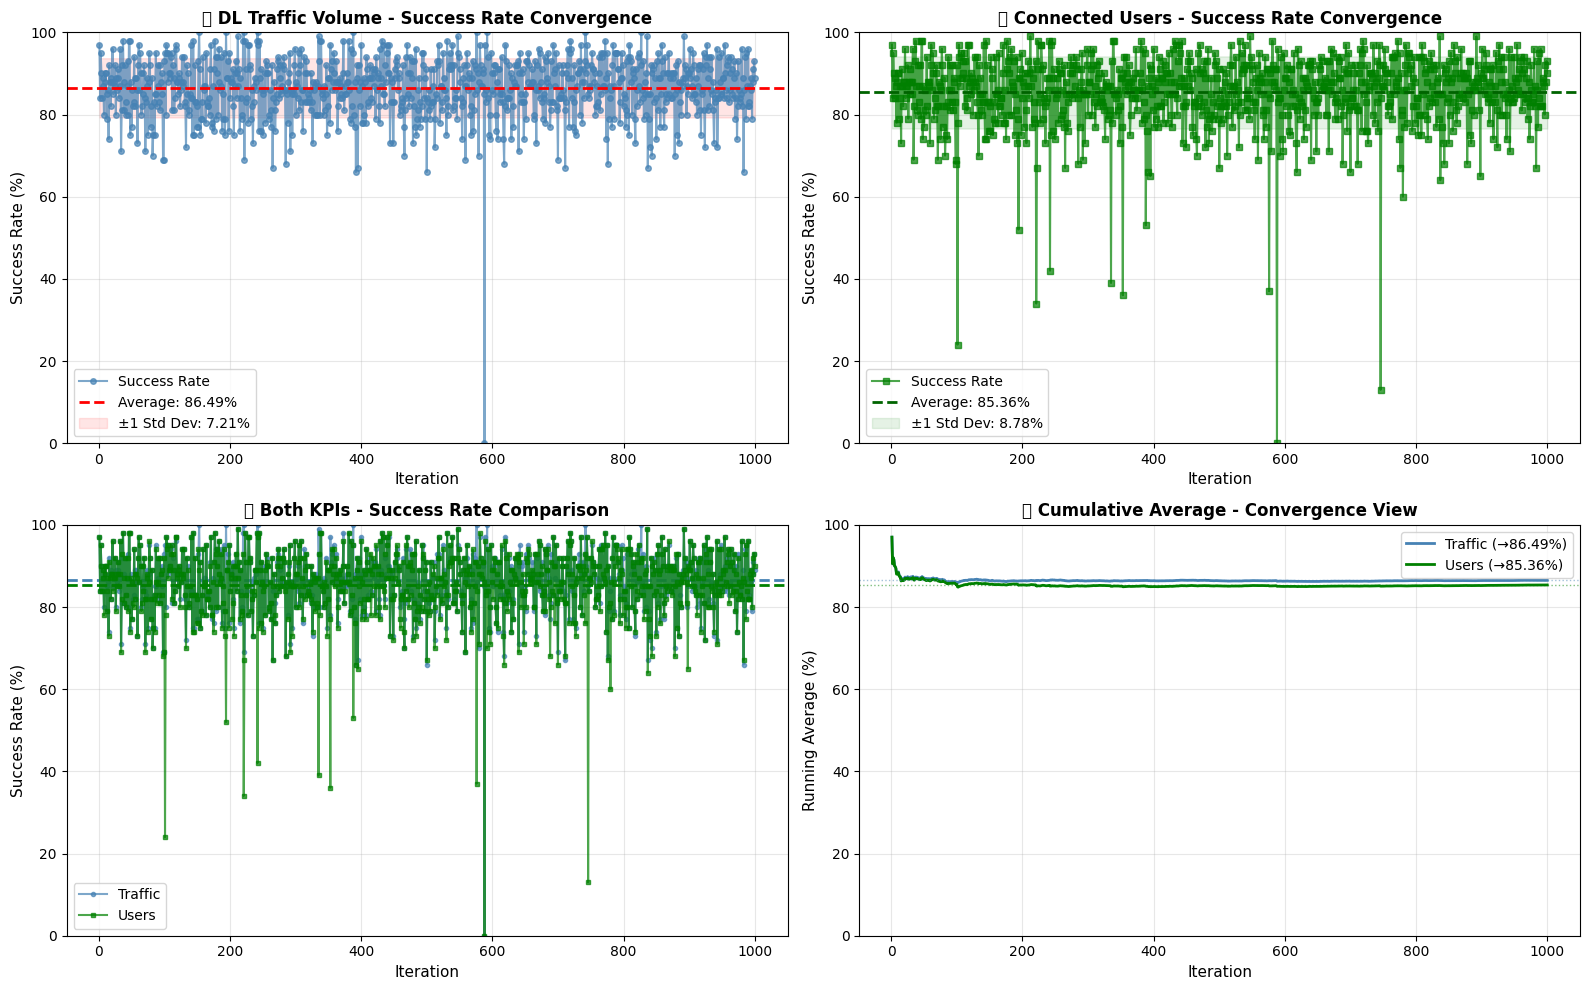

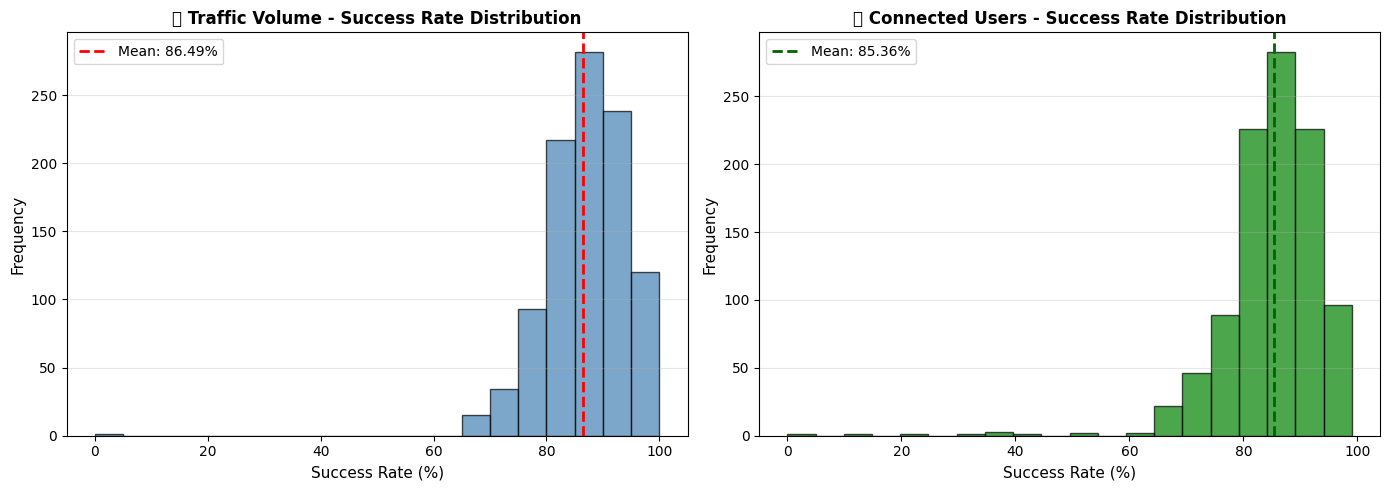


📋 Results DataFrame (First 10 rows):
   Iteration  Traffic_Success_Rate_%  Users_Success_Rate_%  Traffic_MSE  \
0          1                    97.0                  97.0  1569.297892   
1          2                    84.0                  84.0  5352.267347   
2          3                    95.0                  95.0  2399.346281   
3          4                    90.0                  90.0  3991.430558   
4          5                    84.0                  84.0  6186.393546   
5          6                    89.0                  89.0  4239.316517   
6          7                    87.0                  87.0  4228.698467   
7          8                    80.0                  78.0  6919.993549   
8          9                    88.0                  88.0  4252.682653   
9         10                    90.0                  90.0  3503.012732   

   Traffic_MAE    Users_MSE  Users_MAE  
0    25.882216   414.772468  15.478422  
1    41.926435  1369.512388  23.640533  
2    27.50291

In [208]:
# Multi-iteration Convergence Analysis for BiViSIONTS (Section 2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)



# Configuration
NUM_ITERATIONS = 1000  # Number of times to run the test
MASK_RATIO = 0.85   # Mask ratio used in MAE

print(f"🔄 Running BiViSIONTS {NUM_ITERATIONS} iterations for convergence analysis...")
print("=" * 80)

# Storage for results
traffic_success_rates = []
users_success_rates = []
traffic_mse_list = []
traffic_mae_list = []
users_mse_list = []
users_mae_list = []

# Run multiple iterations
for iteration in range(NUM_ITERATIONS):
    # Set different random seed for each iteration to get different mask patterns
    seed = 42 + iteration
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Create input image (same data, different reconstruction due to random masking)
    input_img_full, norm_params_full = bivariate_complex_v2(full_traffic, full_users)
    
    # Convert to tensor
    x_tensor = ToTensor()(input_img_full).unsqueeze(0).to(DEVICE)
    
    # Run forward pass through MAE with random masking
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=MASK_RATIO)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    # Convert reconstruction back to image
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode both variables
    recon_traffic_full, recon_users_full = complex_to_bivariate_v2(recon_img, norm_params_full)
    
    # Extract forecast portions
    forecast_traffic = recon_traffic_full[-PRED_LEN:]
    forecast_users = recon_users_full[-PRED_LEN:]
    
    # Calculate metrics for Traffic
    mse_traffic = mean_squared_error(y_traffic, forecast_traffic)
    mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
    success_traffic = (np.abs(forecast_traffic - y_traffic) <= 0.10 * np.abs(y_traffic)).sum() / len(y_traffic)
    
    # Calculate metrics for Users
    mse_users = mean_squared_error(y_users, forecast_users)
    mae_users = mean_absolute_error(y_users, forecast_users)
    success_users = (np.abs(forecast_users - y_users) <= 0.10 * np.abs(y_users)).sum() / len(y_users)
    
    # Store results
    traffic_success_rates.append(success_traffic * 100)
    users_success_rates.append(success_users * 100)
    traffic_mse_list.append(mse_traffic)
    traffic_mae_list.append(mae_traffic)
    users_mse_list.append(mse_users)
    users_mae_list.append(mae_users)
    
    # Print progress every 10 iterations
    if (iteration + 1) % 10 == 0:
        print(f"✓ Completed {iteration + 1}/{NUM_ITERATIONS} iterations")

print("=" * 80)
print("✅ All iterations completed!")
print()

# Calculate statistics
traffic_avg = np.mean(traffic_success_rates)
traffic_std = np.std(traffic_success_rates)
users_avg = np.mean(users_success_rates)
users_std = np.std(users_success_rates)

print("📊 CONVERGENCE STATISTICS")
print("=" * 80)
print(f"\n🔴 DL Traffic Volume:")
print(f"  Average Success Rate: {traffic_avg:.2f}%")
print(f"  Std Deviation: {traffic_std:.2f}%")
print(f"  Min: {min(traffic_success_rates):.2f}%")
print(f"  Max: {max(traffic_success_rates):.2f}%")
print(f"  Average MSE: {np.mean(traffic_mse_list):.4f}")
print(f"  Average MAE: {np.mean(traffic_mae_list):.4f}")

print(f"\n🟢 Connected Users:")
print(f"  Average Success Rate: {users_avg:.2f}%")
print(f"  Std Deviation: {users_std:.2f}%")
print(f"  Min: {min(users_success_rates):.2f}%")
print(f"  Max: {max(users_success_rates):.2f}%")
print(f"  Average MSE: {np.mean(users_mse_list):.4f}")
print(f"  Average MAE: {np.mean(users_mae_list):.4f}")
print("=" * 80)

# Visualization: Success Rate Convergence
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

iterations = list(range(1, NUM_ITERATIONS + 1))

# Plot 1: Traffic Success Rate with Average Line
axes[0, 0].plot(iterations, traffic_success_rates, marker='o', markersize=4, 
                linewidth=1.5, color='steelblue', alpha=0.7, label='Success Rate')
axes[0, 0].axhline(y=traffic_avg, color='red', linestyle='--', linewidth=2, 
                   label=f'Average: {traffic_avg:.2f}%')
axes[0, 0].fill_between(iterations, traffic_avg - traffic_std, traffic_avg + traffic_std, 
                        color='red', alpha=0.1, label=f'±1 Std Dev: {traffic_std:.2f}%')
axes[0, 0].set_xlabel('Iteration', fontsize=11)
axes[0, 0].set_ylabel('Success Rate (%)', fontsize=11)
axes[0, 0].set_title('🔴 DL Traffic Volume - Success Rate Convergence', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 100])

# Plot 2: Users Success Rate with Average Line
axes[0, 1].plot(iterations, users_success_rates, marker='s', markersize=4, 
                linewidth=1.5, color='green', alpha=0.7, label='Success Rate')
axes[0, 1].axhline(y=users_avg, color='darkgreen', linestyle='--', linewidth=2, 
                   label=f'Average: {users_avg:.2f}%')
axes[0, 1].fill_between(iterations, users_avg - users_std, users_avg + users_std, 
                        color='green', alpha=0.1, label=f'±1 Std Dev: {users_std:.2f}%')
axes[0, 1].set_xlabel('Iteration', fontsize=11)
axes[0, 1].set_ylabel('Success Rate (%)', fontsize=11)
axes[0, 1].set_title('🟢 Connected Users - Success Rate Convergence', 
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 100])

# Plot 3: Combined Success Rates
axes[1, 0].plot(iterations, traffic_success_rates, marker='o', markersize=3, 
                linewidth=1.5, color='steelblue', alpha=0.7, label='Traffic')
axes[1, 0].axhline(y=traffic_avg, color='steelblue', linestyle='--', linewidth=2)
axes[1, 0].plot(iterations, users_success_rates, marker='s', markersize=3, 
                linewidth=1.5, color='green', alpha=0.7, label='Users')
axes[1, 0].axhline(y=users_avg, color='green', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Iteration', fontsize=11)
axes[1, 0].set_ylabel('Success Rate (%)', fontsize=11)
axes[1, 0].set_title('📊 Both KPIs - Success Rate Comparison', 
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='best')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 100])

# Plot 4: Running Average (Cumulative Mean)
traffic_running_avg = [np.mean(traffic_success_rates[:i+1]) for i in range(NUM_ITERATIONS)]
users_running_avg = [np.mean(users_success_rates[:i+1]) for i in range(NUM_ITERATIONS)]

axes[1, 1].plot(iterations, traffic_running_avg, linewidth=2, 
                color='steelblue', label=f'Traffic (→{traffic_avg:.2f}%)')
axes[1, 1].plot(iterations, users_running_avg, linewidth=2, 
                color='green', label=f'Users (→{users_avg:.2f}%)')
axes[1, 1].axhline(y=traffic_avg, color='steelblue', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 1].axhline(y=users_avg, color='green', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Iteration', fontsize=11)
axes[1, 1].set_ylabel('Running Average (%)', fontsize=11)
axes[1, 1].set_title('📈 Cumulative Average - Convergence View', 
                     fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Additional: Distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(traffic_success_rates, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=traffic_avg, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {traffic_avg:.2f}%')
axes[0].set_xlabel('Success Rate (%)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('🔴 Traffic Volume - Success Rate Distribution', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].hist(users_success_rates, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(x=users_avg, color='darkgreen', linestyle='--', linewidth=2, 
                label=f'Mean: {users_avg:.2f}%')
axes[1].set_xlabel('Success Rate (%)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('🟢 Connected Users - Success Rate Distribution', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Save results to DataFrame
results_df = pd.DataFrame({
    'Iteration': iterations,
    'Traffic_Success_Rate_%': traffic_success_rates,
    'Users_Success_Rate_%': users_success_rates,
    'Traffic_MSE': traffic_mse_list,
    'Traffic_MAE': traffic_mae_list,
    'Users_MSE': users_mse_list,
    'Users_MAE': users_mae_list
})

print("\n📋 Results DataFrame (First 10 rows):")
print(results_df.head(10))

# Summary statistics
print("\n📊 SUMMARY STATISTICS")
print("=" * 80)
print(results_df.describe())
print("=" * 80)